## Import Python libarys

In [1]:
# general
import numpy as np
import pandas as pd
from datetime import datetime, date

# plot libarys
import matplotlib.pyplot as plt
import seaborn as sns

# further libarys
import warnings

# saveing
import pickle

## Load data

In [2]:
## new data:
with open('data/orig_ts2_new.csv', 'rb') as f:
    df_one, df_two, df_three = pickle.load(f)

In [3]:
df_one.query('year == 2021').sort_values(by='date').tail()

,amount_sold,amount_delivered,timestamp,date,year,month,week,day,dayofyear,weekday
5377,48.0,50,2021-04-10,2021-04-10,2021,4,14,10,100,5
5380,60.0,60,2021-04-11,2021-04-11,2021,4,14,11,101,6
5383,55.0,55,2021-04-12,2021-04-12,2021,4,15,12,102,0
5386,55.0,55,2021-04-13,2021-04-13,2021,4,15,13,103,1
5389,64.0,65,2021-04-14,2021-04-14,2021,4,15,14,104,2


In [4]:
print(f'start date article one {df_one.date.min()} and end date {df_one.date.max()}')
print(f'start date article two {df_two.date.min()} and end date {df_two.date.max()}')
print(f'start date article three {df_three.date.min()} and end date {df_three.date.max()}')

start date article one 2012-01-16 and end date 2021-04-14
start date article two 2012-01-02 and end date 2021-04-14
start date article three 2012-01-02 and end date 2021-04-14


In [5]:
df_one.head()

,amount_sold,amount_delivered,timestamp,date,year,month,week,day,dayofyear,weekday
0,9.0,20,2012-01-16,2012-01-16,2012,1,3,16,16,0
1,14.0,20,2012-01-17,2012-01-17,2012,1,3,17,17,1
2,29.0,30,2012-01-18,2012-01-18,2012,1,3,18,18,2
3,13.0,15,2012-01-19,2012-01-19,2012,1,3,19,19,3
4,14.0,25,2012-01-20,2012-01-20,2012,1,3,20,20,4


In [6]:
df_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 993 entries, 0 to 5389
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   amount_sold       993 non-null    float64       
 1   amount_delivered  993 non-null    int64         
 2   timestamp         993 non-null    datetime64[ns]
 3   date              993 non-null    object        
 4   year              993 non-null    int64         
 5   month             993 non-null    int64         
 6   week              993 non-null    int64         
 7   day               993 non-null    int64         
 8   dayofyear         993 non-null    int64         
 9   weekday           993 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 85.3+ KB


In [7]:
# Indexing
df_onet = df_one.copy().set_index('timestamp')
df_twot = df_two.copy().set_index('timestamp')
df_threet = df_three.copy().set_index('timestamp')

In [8]:
df_onet.head(1)

,amount_sold,amount_delivered,date,year,month,week,day,dayofyear,weekday
timestamp,,,,,,,,,
2012-01-16,9.0,20,2012-01-16,2012,1,3,16,16,0


# R libarys

In [9]:
#%load_ext rpy2.ipython
%reload_ext rpy2.ipython

In [10]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

In [11]:
r = robjects.r
base = importr('base')
forecast = importr('forecast')
graphics = importr('graphics')
grdevices = importr('grDevices')
ggplot2 = importr('ggplot2')

In [12]:
dplyr = importr('dplyr')
urca = importr('urca')

In [13]:
zoo = importr('zoo')
xts = importr("xts", robject_translations = {".subset.xts": "_subset_xts2", 
                                             "to.period": "to_period2"})

In [14]:
seasonal = importr('seasonal')

In [15]:
Metrics = importr('Metrics')

# Global setting plot window

In [16]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

In [17]:
# Note set.seed only works once, otherwise it will give an error or you need to restart the kernel

In [18]:
%R set.seed(1)

# Data preperation
+ Transform to R-object
+ Filling the gaps with zeros
+ create dummy variable (zero if ts-value = zero, otherwise 1)
+ split in train and test

In [19]:
%%R -i df_one
# Create a date sequence
all_dates <- allDates <- seq.Date(as.Date(df_one[1,'timestamp']),
                                  as.Date(df_one[dim(df_one)[1],'timestamp']),"day")
# Transform the timestamp to a Date object
article_one_with_date <- df_one %>% mutate(timestamp = as.Date(timestamp)) %>% 
    select(timestamp, amount_sold)
df_one_daily <- merge(x = data.frame(timestamp=all_dates),
                      y = article_one_with_date, 
                      all.x = TRUE)
head(df_one_daily)

   timestamp amount_sold
1 2012-01-15           9
2 2012-01-16          14
3 2012-01-17          29
4 2012-01-18          13
5 2012-01-19          14
6 2012-01-20          15


In [20]:
%%R 

print(summary(df_one_daily))
sapply(df_one_daily, typeof)

   timestamp           amount_sold    
 Min.   :2012-01-15   Min.   :  0.00  
 1st Qu.:2014-05-08   1st Qu.: 46.00  
 Median :2016-08-29   Median : 66.00  
 Mean   :2016-08-29   Mean   : 71.07  
 3rd Qu.:2018-12-21   3rd Qu.: 92.00  
 Max.   :2021-04-13   Max.   :203.00  
                      NA's   :2384    
  timestamp amount_sold 
   "double"    "double" 


In [21]:
%%R
# Create a time series with daily frequency
one_daily_full <- ts(df_one_daily['amount_sold'], start = c(2012, df_one[1,'dayofyear']), 
                     end = c(2021, df_one[dim(df_one)[1]-1, 'dayofyear']), frequency = 365)
                    
autoplot(one_daily_full) +
    xlab('dayofyear') +
    ylab('amount_sold') +
    ggtitle('ts with gaps') -> ts_with_gaps

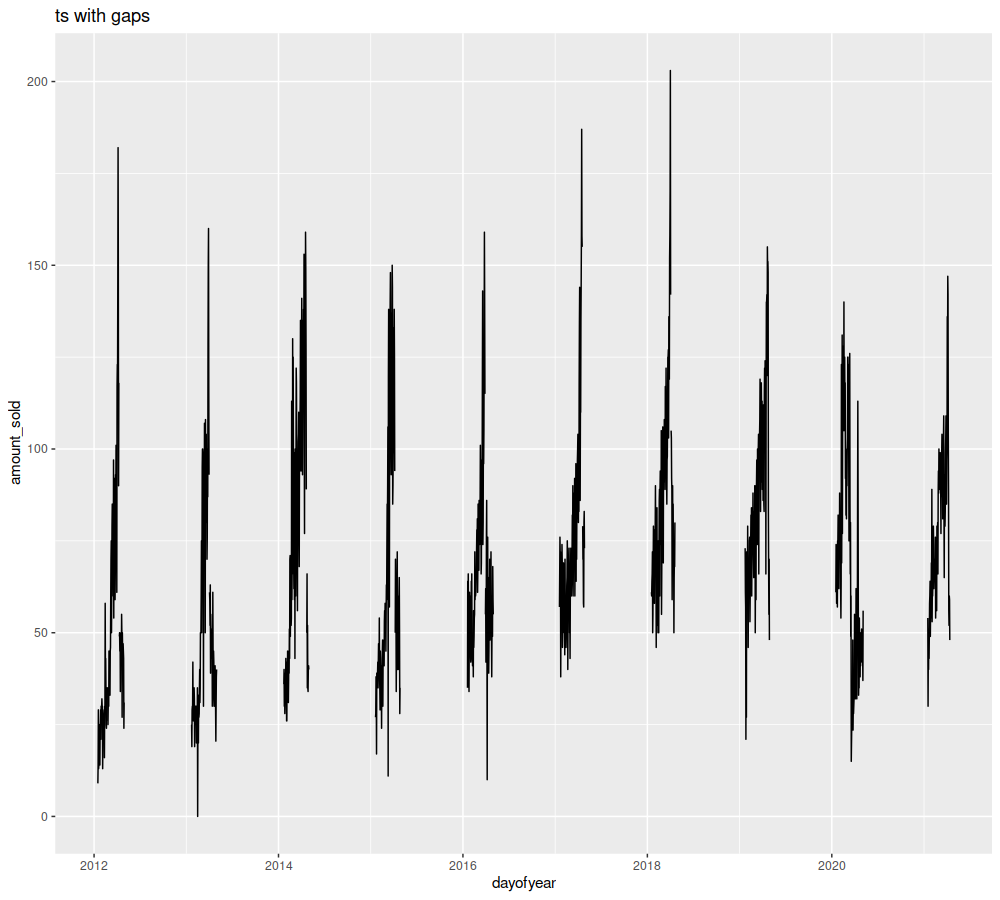

In [22]:
%%R 

ts_with_gaps

In [23]:
%%R
# Create an indicator for the sales period
dum <- as.integer(is.na(one_daily_full))
# Set the other NA values adn replace them with zeros
one_daily_full_zero <- one_daily_full
one_daily_full_zero[is.na(one_daily_full_zero)] <- 0
autoplot(one_daily_full_zero) +
    xlab('dayofyear') +
    ylab('amount_sold') +
    ggtitle('ts zero filled') -> ts_zero_filled

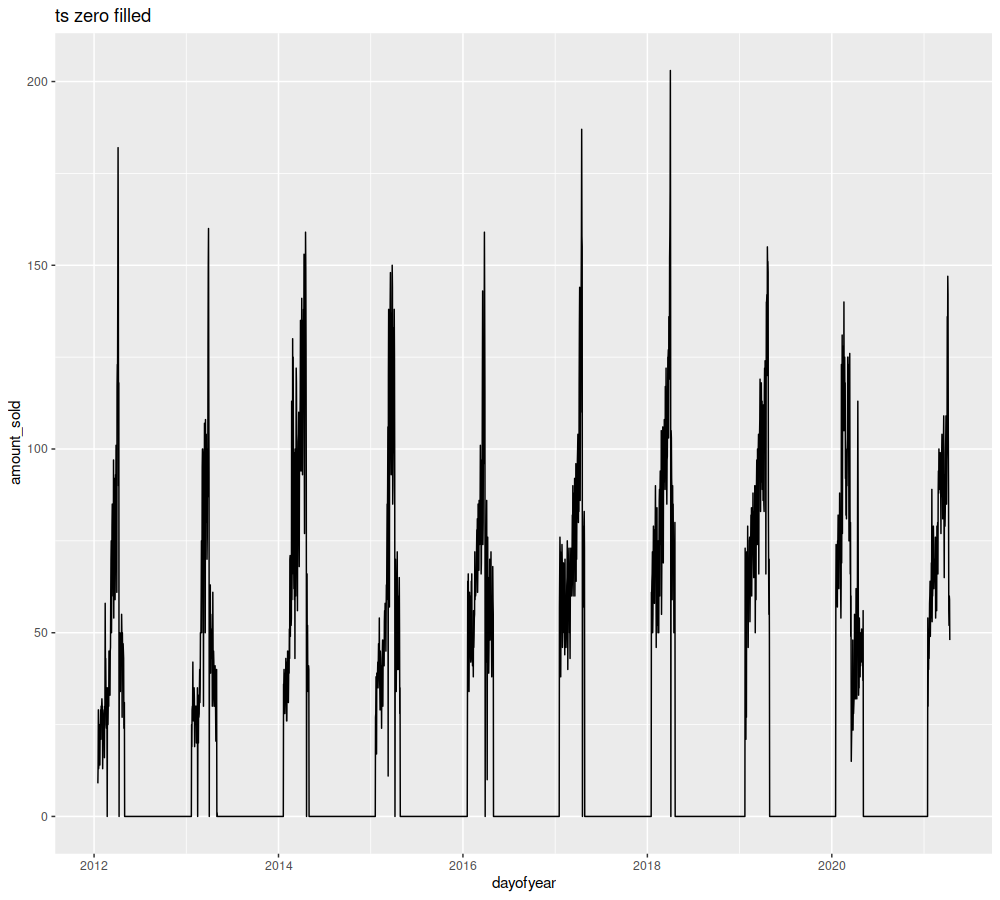

In [24]:
%%R

ts_zero_filled

In [25]:
%%R
# Split the data and train and test
train_index <- which(df_one['timestamp'] == "2020-05-02")
one_daily_full_zero_train <- window(one_daily_full_zero, c(2012,df_one[0,'dayofyear']), 
                                    c(2020, df_one[train_index, 'dayofyear']))
one_daily_full_zero_test <- window(one_daily_full_zero, c(2020, df_one[train_index, 'dayofyear']+1), 
                                   c(2021,df_one[dim(df_one)[1],'dayofyear']))
# Also split the sales indicator (the dummy) accordingly
one_dum_train <- dum[1:length(one_daily_full_zero_train)]
one_dum_test <- dum[(length(one_daily_full_zero_train)+1):length(dum)]

In [26]:
%%R 

print(length(one_daily_full_zero_train))
print(length(one_daily_full_zero_test))

[1] 3028
[1] 345


# Model choice

To determine whether ML models can be improved by using multiple seasonalities, three common models were used.

First, seasonal naïve, which is a typical baseline model. This is not the simplest baseline model, but the one that can also represent seasonality. In this way, it can also be investigated whether even such a simple model can benefit from multiple seasonalities.

Secondly, a representative of the ARMA models. Even though it is always described as SARIMA instead of ARIMA in the following, the model found using auto.arima() is usually an ARIMA model, since it either does not find the seasonality (or the inclusion does not lead to a better model) or all seasonalities are already given. In the latter case, it is recommended to set seasonal=FALSE as it would only take up unnecessary computing time.

Finally, a representative of the smoothing models is the TBATS model (Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components).

For the latter two, dummy variables are also used as regressors to model the sales periods.

# Forecasting

# Baseline model: Seasonal naiv 

In [28]:
%%R

fc_sn <- snaive(one_daily_full_zero_train, h=length(one_daily_full_zero_test))

autoplot(fc_sn) -> plot_fc_sn

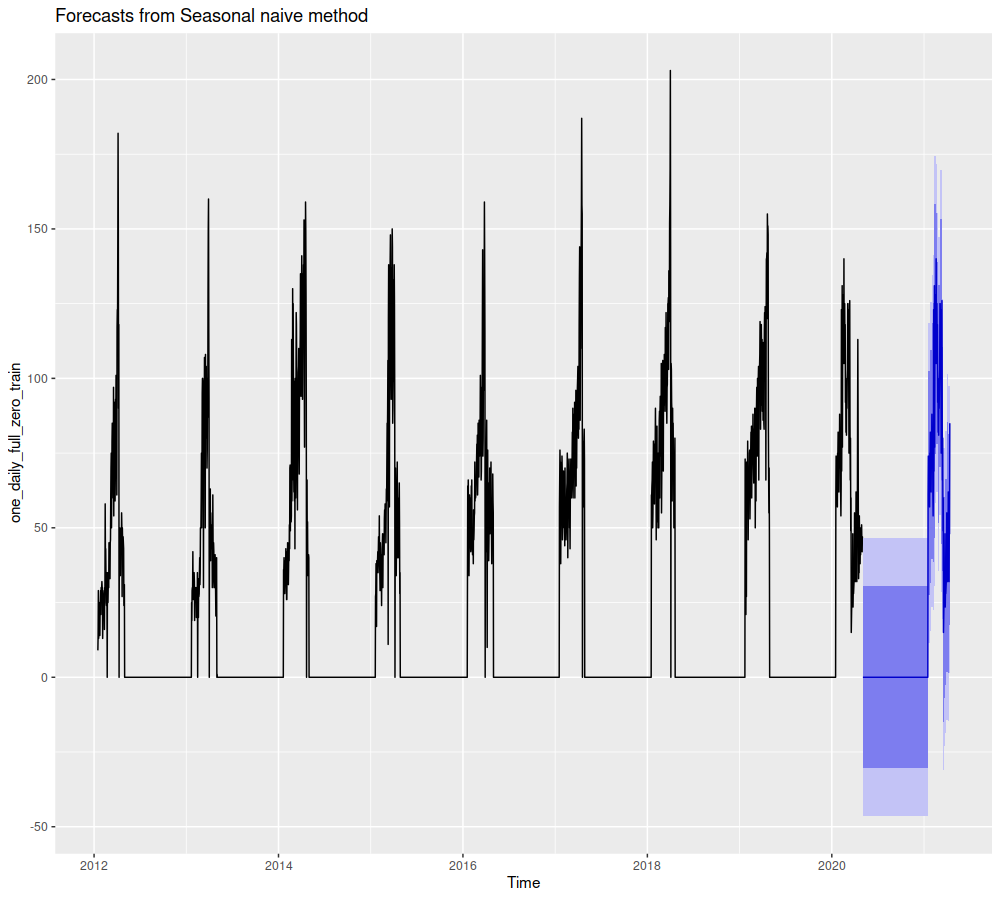

In [29]:
%%R

plot_fc_sn

In [30]:
%%R

mse_sn = mse(fc_sn$mean,one_daily_full_zero_test)
rmse_sn = rmse(fc_sn$mean,one_daily_full_zero_test)

print(mse_sn)
print(rmse_sn)

[1] 479.5978
[1] 21.89972



	Ljung-Box test

data:  Residuals from Seasonal naive method
Q* = 11300, df = 606, p-value < 2.2e-16

Model df: 0.   Total lags used: 606



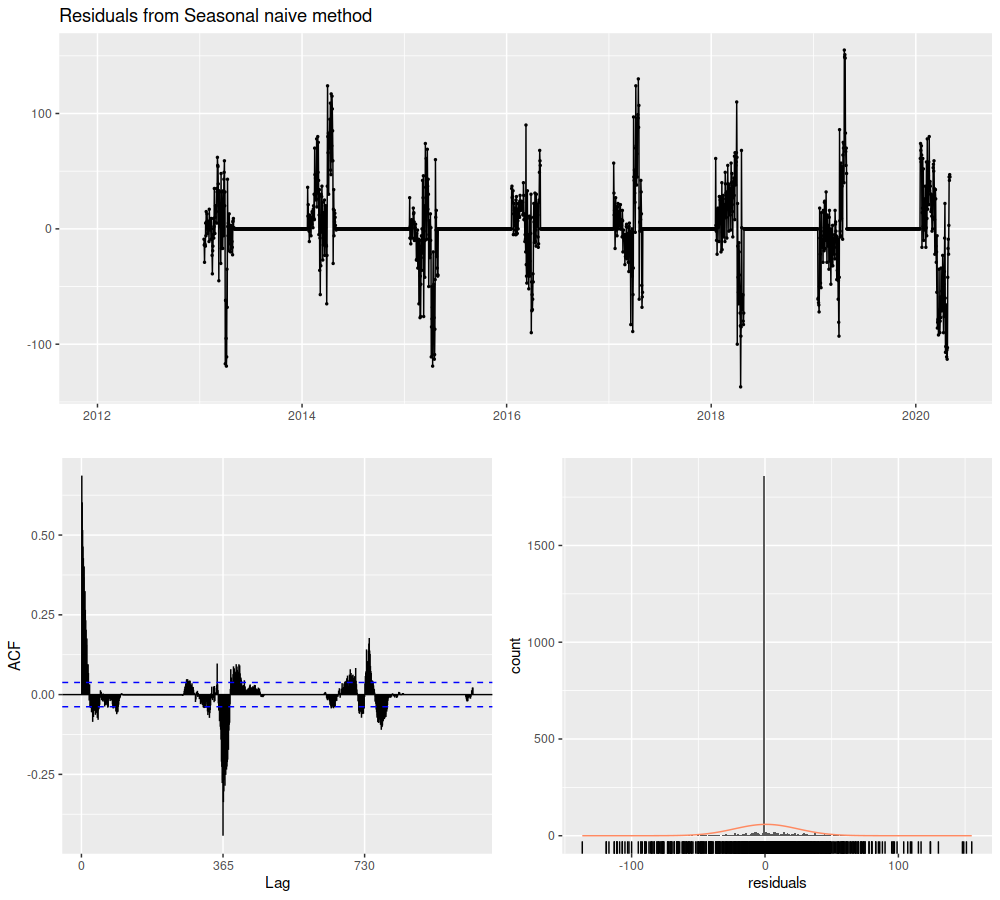

In [134]:
%%R 

checkresiduals(fc_sn)

# SARIMA

In [32]:
%%R 

fit_sarima <- auto.arima(one_daily_full_zero_train)

fit_sarima %>% forecast(h=length(one_daily_full_zero_test)) -> fc_sarima

autoplot(fc_sarima) -> plot_fc_sarima

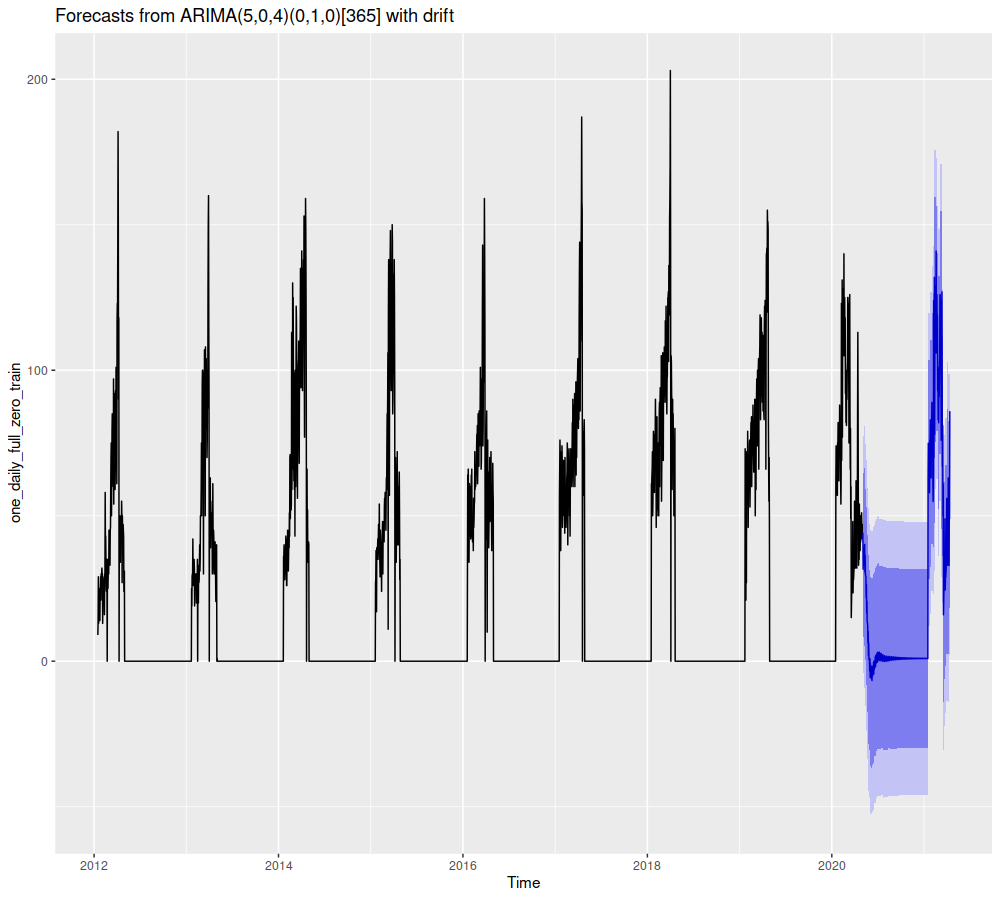

In [33]:
%%R 

plot_fc_sarima

In [34]:
%%R

summary(fit_sarima)

Series: one_daily_full_zero_train 
ARIMA(5,0,4)(0,1,0)[365] with drift 

Coefficients:
         ar1     ar2      ar3      ar4     ar5      ma1      ma2     ma3
      0.5393  1.4254  -0.4256  -0.9529  0.3833  -0.0116  -1.2782  -0.245
s.e.  0.0524  0.0421   0.0760   0.0333  0.0458   0.0472   0.0509   0.051
         ma4   drift
      0.6753  0.0026
s.e.  0.0372  0.0039

sigma^2 estimated as 261.1:  log likelihood=-11184.02
AIC=22390.04   AICc=22390.14   BIC=22454.8

Training set error measures:
                     ME     RMSE      MAE MPE MAPE    MASE        ACF1
Training set 0.01504102 15.12475 5.998921 NaN  Inf 0.62096 0.003029015


In [128]:
%%R

mse_sarima = mse(fc_sarima$mean,one_daily_full_zero_test)
rmse_sarima = rmse(fc_sarima$mean,one_daily_full_zero_test)

print(mse_sarima)
print(rmse_sarima)

[1] 513.787
[1] 22.66687



	Ljung-Box test

data:  Residuals from ARIMA(5,0,4)(0,1,0)[365] with drift
Q* = 1482.1, df = 596, p-value < 2.2e-16

Model df: 10.   Total lags used: 606



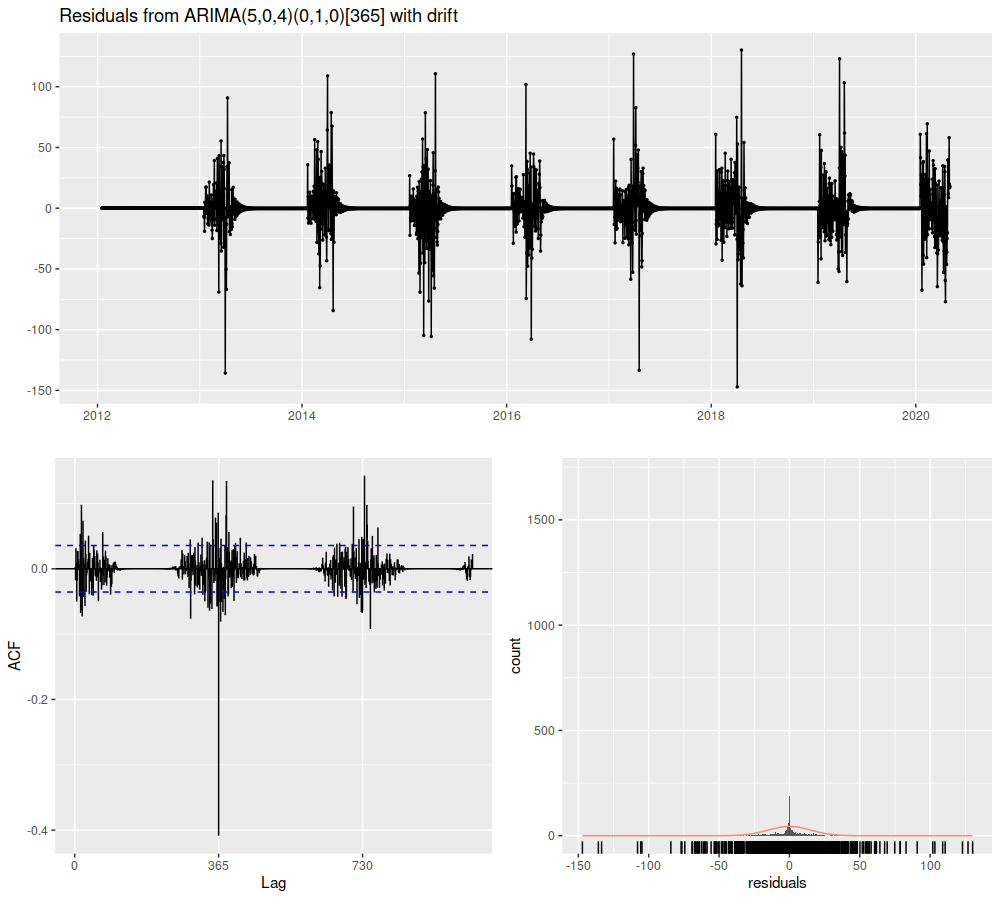

In [36]:
%%R 

checkresiduals(fc_sarima)

# SARIMA + dummy variables

In [37]:
%%R 

fit_sarima_dum <- auto.arima(one_daily_full_zero_train, xreg=one_dum_train)

fit_sarima_dum %>% forecast(xreg=one_dum_test, h=length(one_daily_full_zero_test)) -> fc_sarima_dum

autoplot(fc_sarima_dum) -> plot_fc_sarima_dum

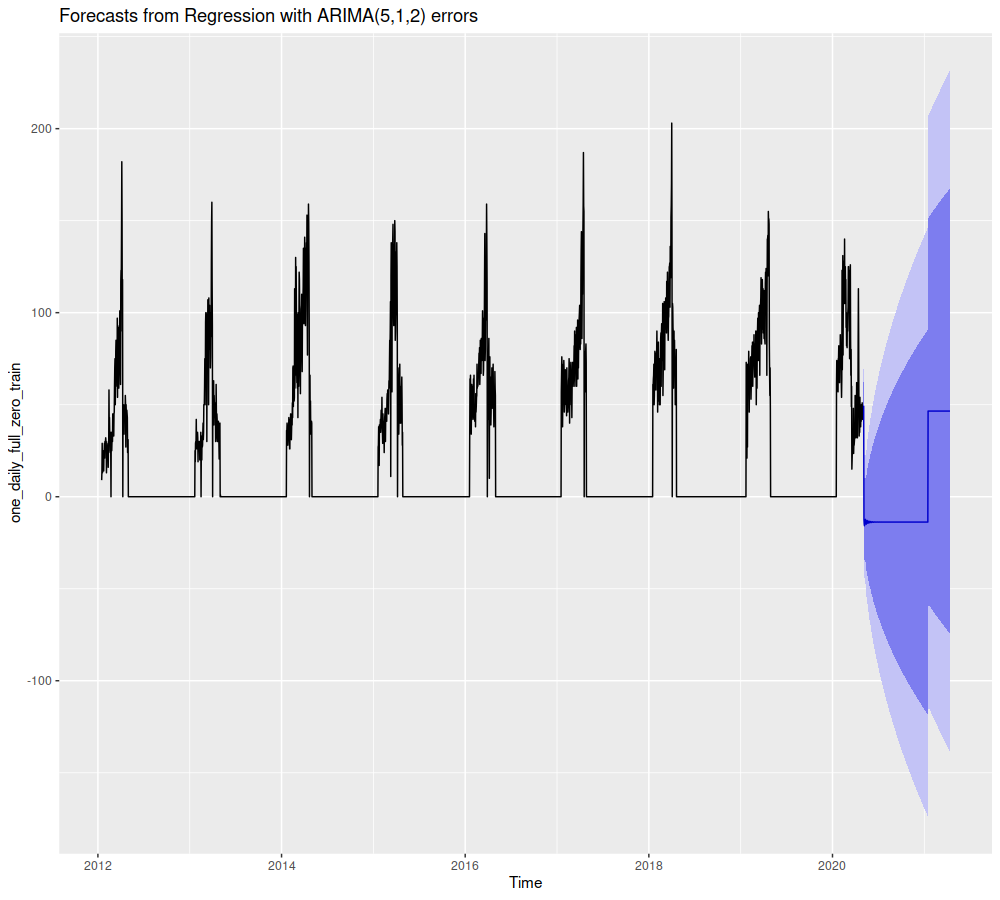

In [38]:
%%R

plot_fc_sarima_dum

In [110]:
%%R

summary(fit_sarima_dum)

Series: one_daily_full_zero_train 
Regression with ARIMA(5,1,2) errors 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1     ma2      xreg
      0.5628  -0.5626  -0.2409  -0.1228  -0.1502  -0.9823  0.7430  -60.3131
s.e.  0.0694   0.0415   0.0244   0.0206   0.0221   0.0678  0.0616    1.7557

sigma^2 estimated as 101.4:  log likelihood=-11282.22
AIC=22582.43   AICc=22582.49   BIC=22636.57

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set 0.02377679 10.05436 4.062412 NaN  Inf 0.4205082 -0.002919251


In [111]:
%%R

mse_sarima_dum = mse(fc_sarima_dum$mean,one_daily_full_zero_test)
rmse_sarima_dum = rmse(fc_sarima_dum$mean,one_daily_full_zero_test)

print(mse_sarima_dum)
print(rmse_sarima_dum)

[1] 523.3078
[1] 22.87592



	Ljung-Box test

data:  Residuals from Regression with ARIMA(5,1,2) errors
Q* = 1575.2, df = 598, p-value < 2.2e-16

Model df: 8.   Total lags used: 606



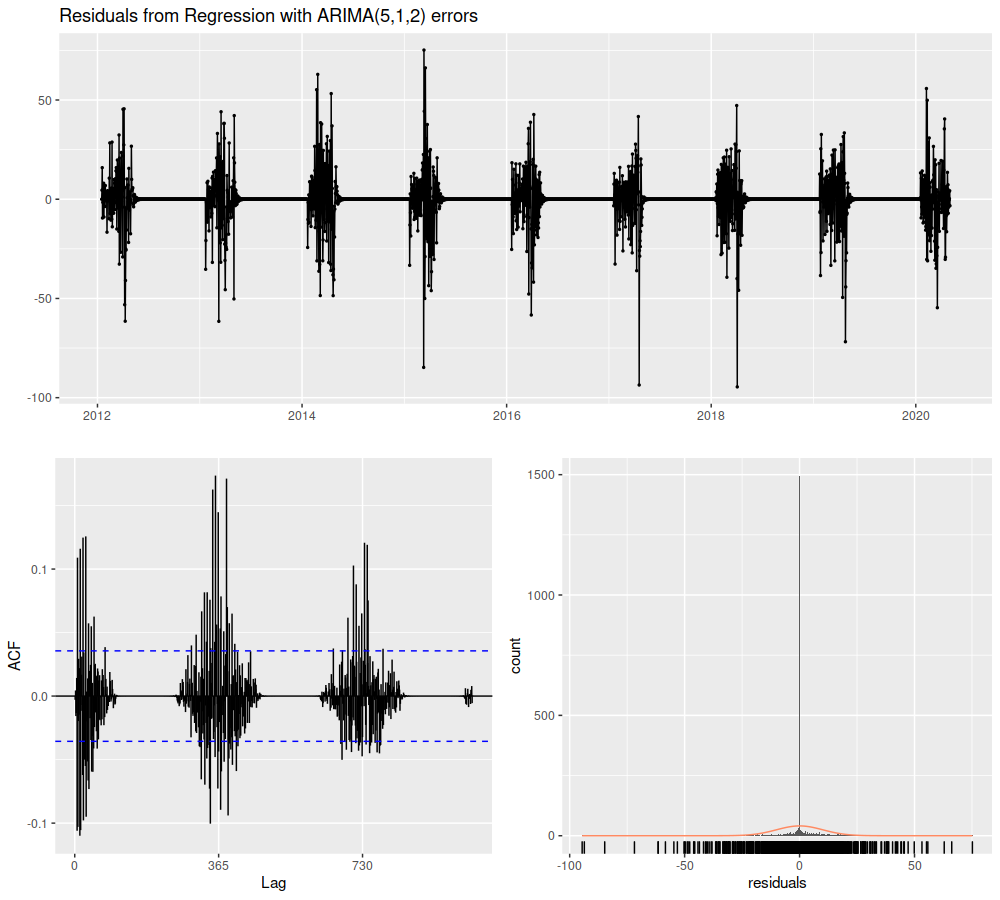

In [44]:
%%R 

checkresiduals(fc_sarima_dum)

# TBATS

In [45]:
%%R

one_daily_full_zero_train %>% tbats -> fit_tbats

fit_tbats %>% forecast(h=length(one_daily_full_zero_test)) -> fc_tbats

autoplot(fc_tbats) -> plot_fc_tbats

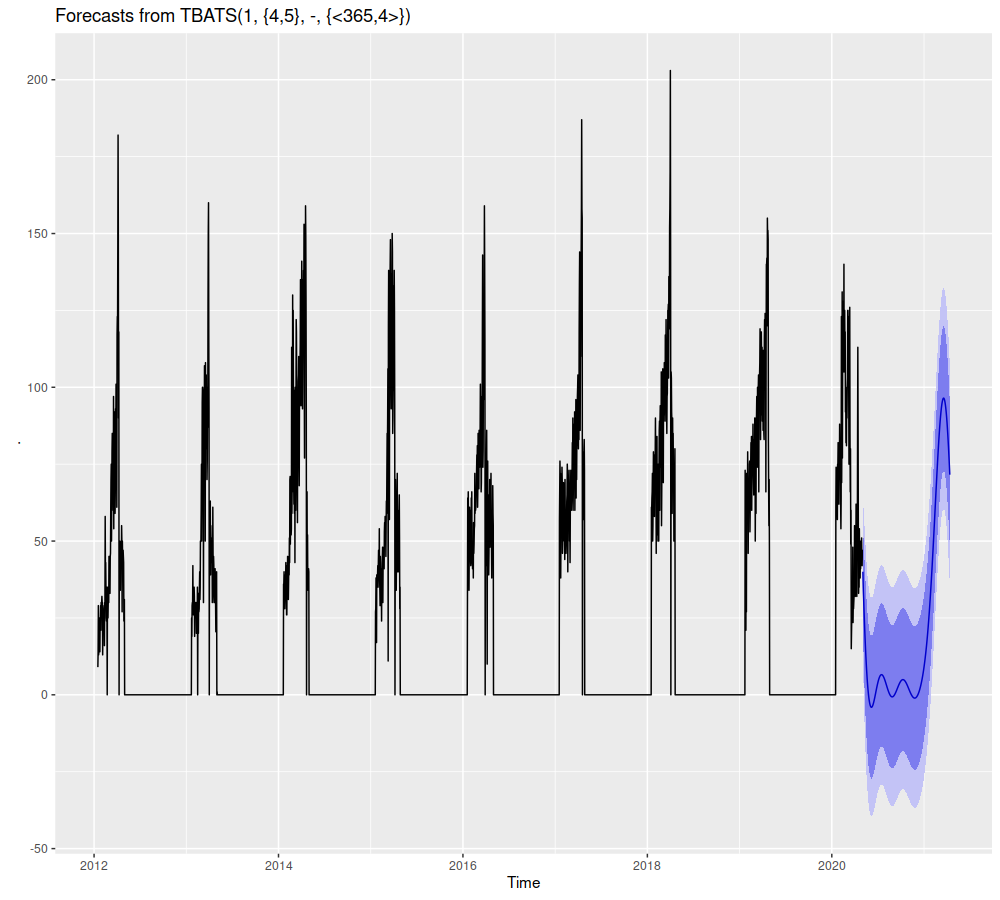

In [48]:
%%R

plot_fc_tbats

In [49]:
%%R

mse_tbats = mse(fc_tbats$mean,one_daily_full_zero_test)
rmse_tbats = rmse(fc_tbats$mean,one_daily_full_zero_test)

print(mse(fc_tbats$mean,one_daily_full_zero_test))
print(rmse(fc_tbats$mean,one_daily_full_zero_test))

[1] 134.8571
[1] 11.6128



	Ljung-Box test

data:  Residuals from TBATS(1, {4,5}, -, {<365,4>})
Q* = 1237.8, df = 576, p-value < 2.2e-16

Model df: 30.   Total lags used: 606



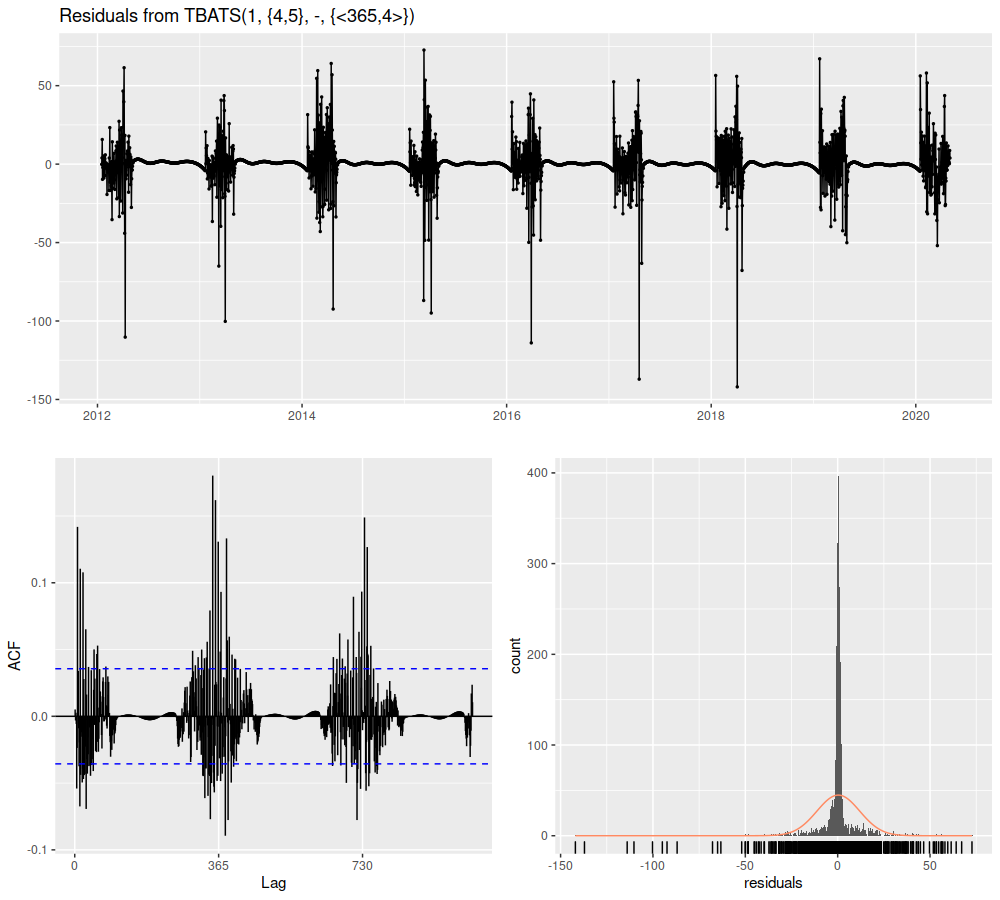

In [50]:
%%R 

checkresiduals(fc_tbats)

# TBATS + dummys variable

In [51]:
%%R

one_daily_full_zero_train %>% tbats(xreg = one_dum_train) -> fit_tbats_dum

fit_tbats_dum %>% forecast(xreg=one_dum_test, h=length(one_daily_full_zero_test)) -> fc_tbats_dum

autoplot(fc_tbats_dum) -> plot_fc_tbats_dum 

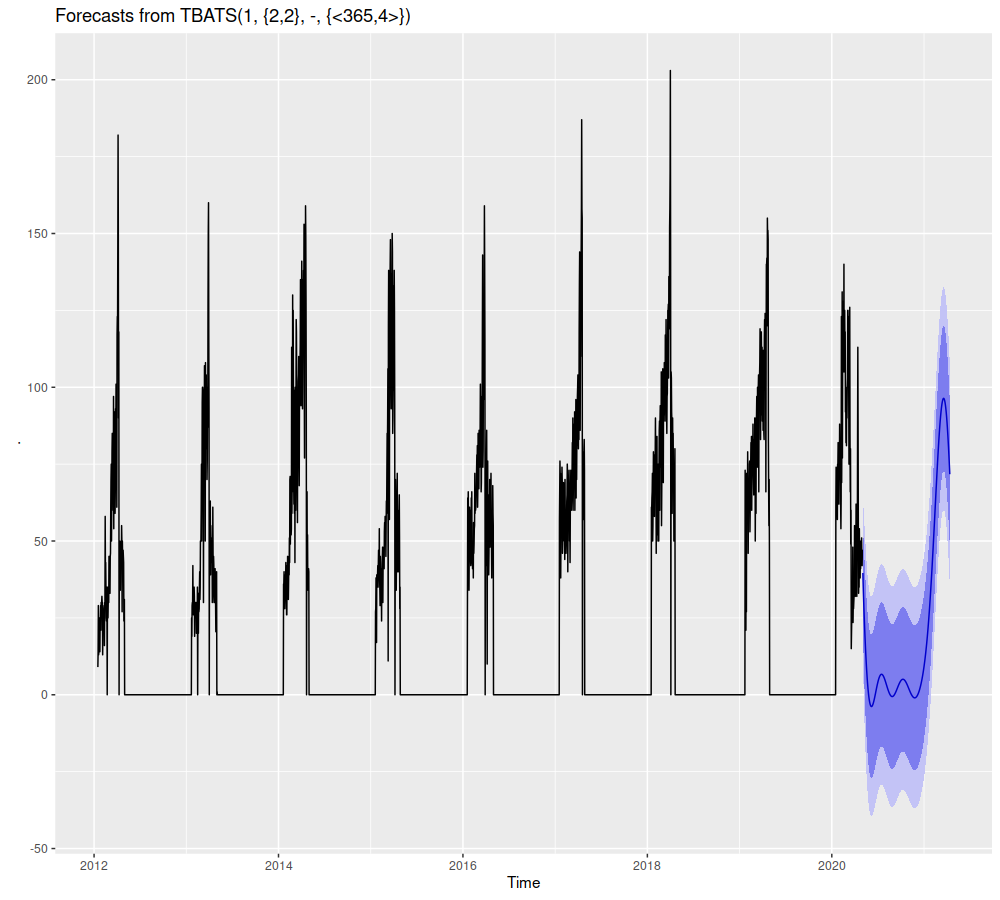

In [54]:
%%R

plot_fc_tbats_dum

In [55]:
%%R

mse_tbats_dum = mse(fc_tbats_dum$mean,one_daily_full_zero_test)
rmse_tbats_dum = rmse(fc_tbats_dum$mean,one_daily_full_zero_test)

print(mse_tbats_dum)
print(rmse_tbats_dum)

[1] 134.8161
[1] 11.61103



	Ljung-Box test

data:  Residuals from TBATS(1, {2,2}, -, {<365,4>})
Q* = 1389.6, df = 586, p-value < 2.2e-16

Model df: 20.   Total lags used: 606



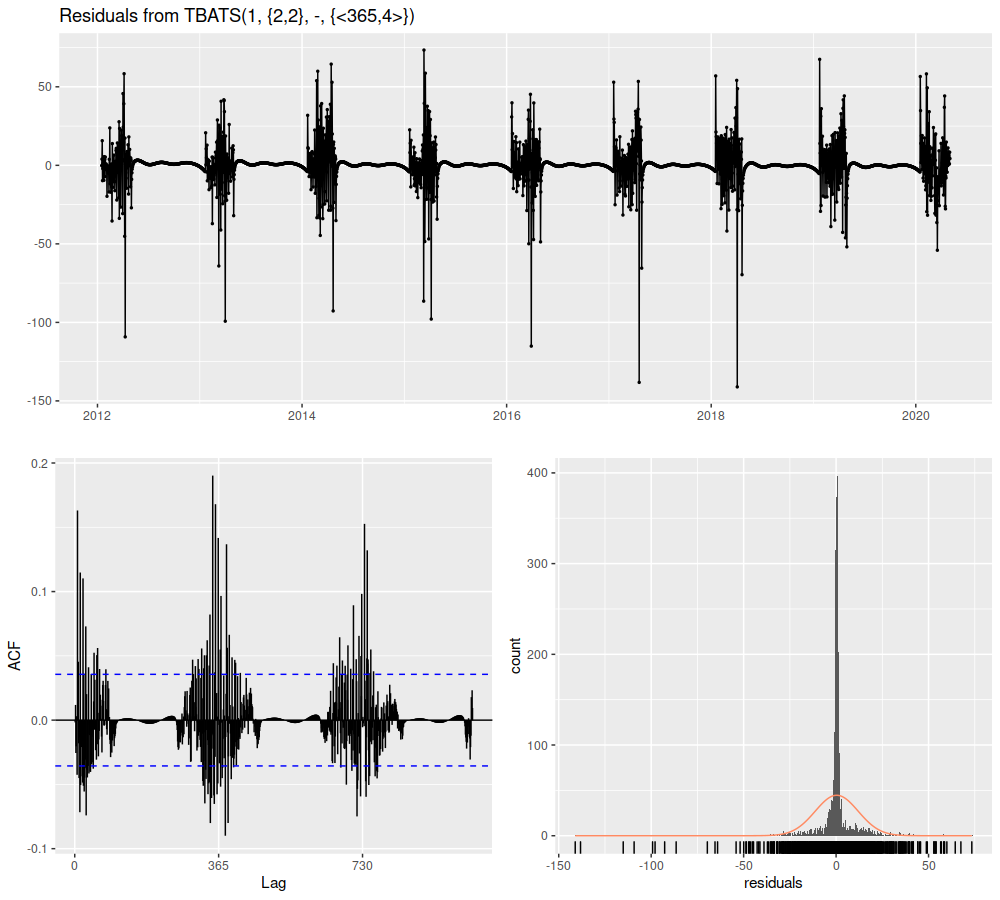

In [90]:
%%R 

checkresiduals(fc_tbats_dum)

# Forecast with Multiseasonality

# Create time series with multiple seasons 
+ analogous as before, but now with msts() instead of ts()
+ seasonalities defined in the EDA notebook (python) 
+ this changes nothing on the curse of the ts. it just adds informations

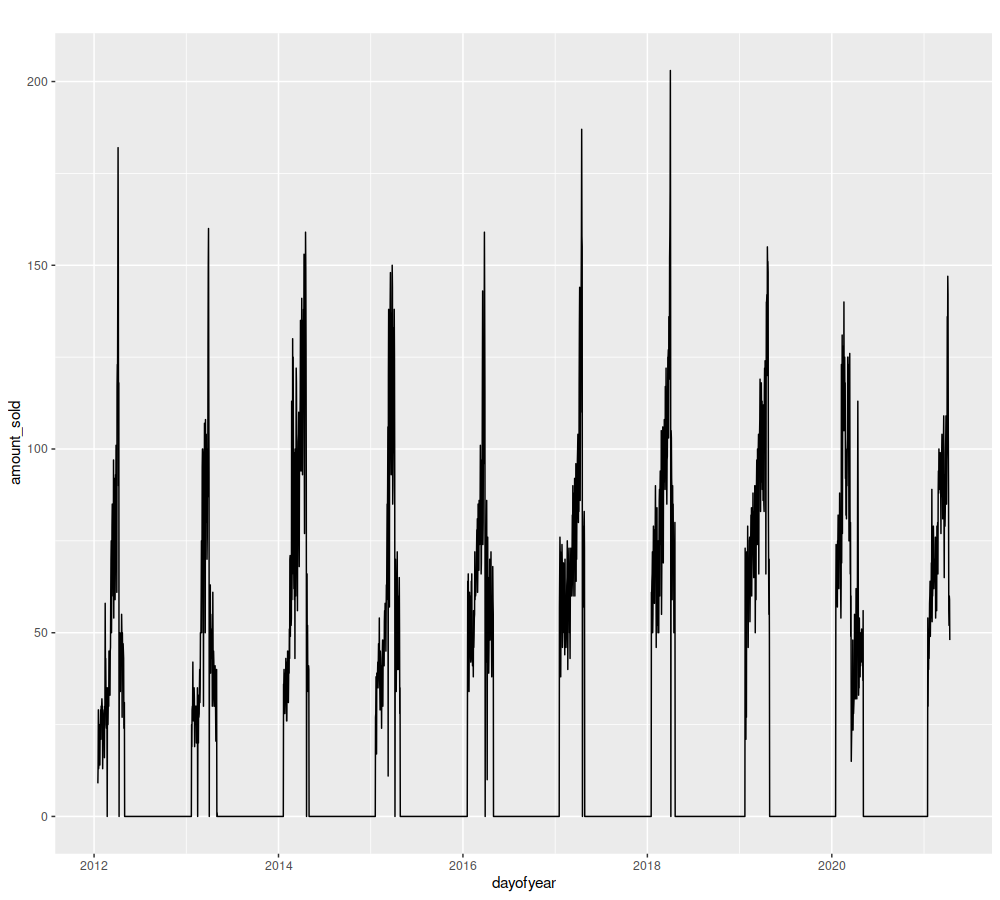

In [56]:
%%R

one_daily_full_ms <- msts(df_one_daily['amount_sold'], start = c(2012, df_one[1,'dayofyear']), 
                     end = c(2021, df_one[dim(df_one)[1]-1, 'dayofyear']), seasonal.periods=c(5,7,12,18,43.5, 53,77,100.11,365.25)) 

# Create an indicator for the sales period
dum_ms <- as.integer(is.na(one_daily_full_ms))
# Set the other NA values
one_daily_full_zero_ms <- one_daily_full_ms
one_daily_full_zero_ms[is.na(one_daily_full_zero_ms)] <- 0
autoplot(one_daily_full_zero_ms) +
    xlab('dayofyear') +
    ylab('amount_sold')

In [57]:
%%R

# split in train and test
train_index_ms <- which(df_one['timestamp'] == "2020-05-02")
one_daily_full_zero_train_ms <- window(one_daily_full_zero_ms, c(2012,df_one[0,'dayofyear']), 
                                    c(2020, df_one[train_index_ms, 'dayofyear']))
one_daily_full_zero_test_ms <- window(one_daily_full_zero_ms, c(2020, df_one[train_index_ms, 'dayofyear']+1), 
                                   c(2021,df_one[dim(df_one)[1],'dayofyear']))
# Also split the sales indicator (the dummy) accordingly
one_dum_train_ms <- dum_ms[1:length(one_daily_full_zero_train_ms)]
one_dum_test_ms <- dum_ms[(length(one_daily_full_zero_train_ms)+1):length(dum_ms)]

In [58]:
%%R 

print(length(one_daily_full_zero_train))
print(length(one_daily_full_zero_test))

[1] 3028
[1] 345


In [59]:
%%R

one_daily_full_zero_ms %>% mstl() %>%
  autoplot() -> decompose_msts

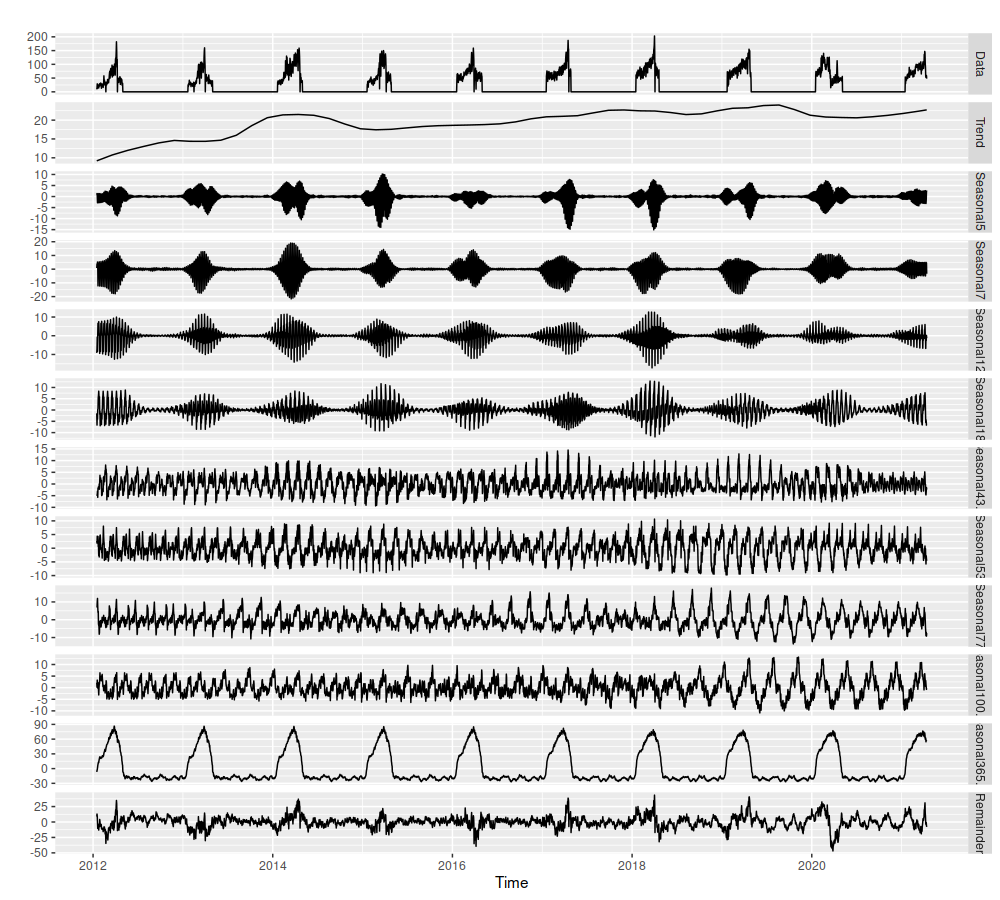

In [60]:
%%R

decompose_msts

# Seasonal Naiv

In [61]:
%%R

fc_sn_ms <- snaive(one_daily_full_zero_train_ms, h=length(one_daily_full_zero_test_ms))

autoplot(fc_sn_ms) -> plot_fc_sn_ms

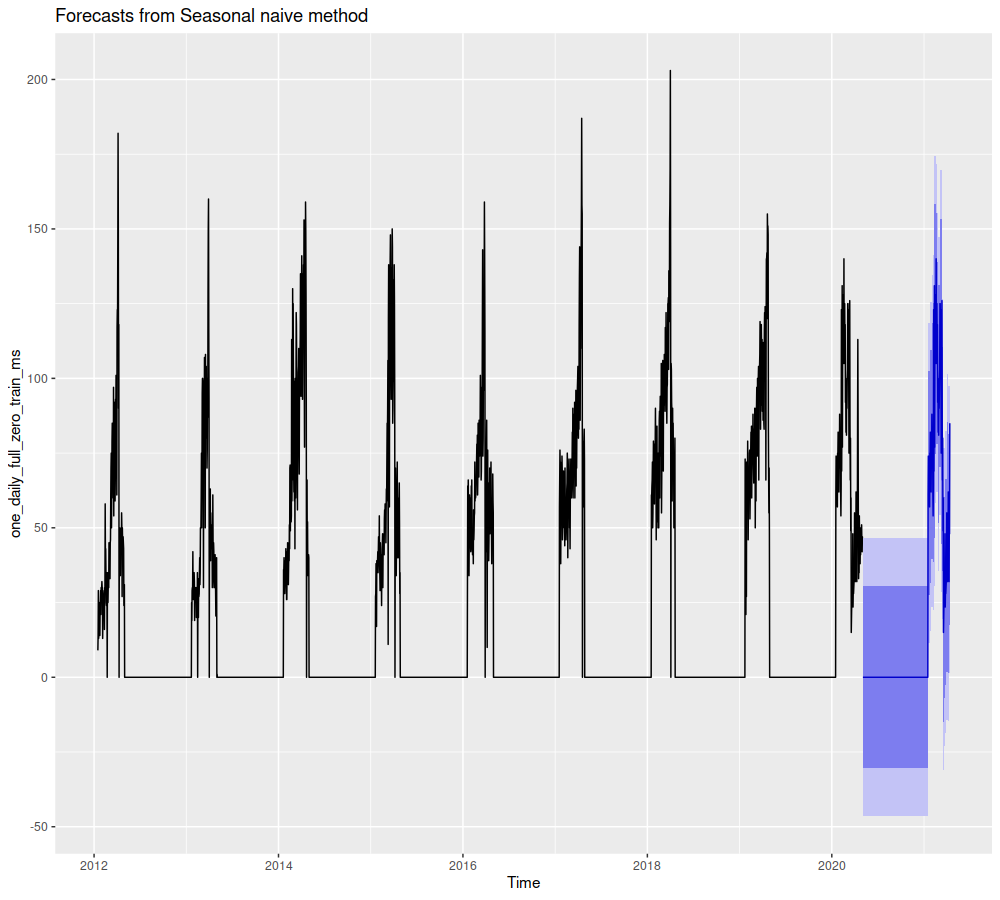

In [62]:
%%R

plot_fc_sn_ms

In [77]:
%%R

mse_sn_ms = mse(fc_sn_ms$mean,one_daily_full_zero_test_ms)
rmse_sn_ms = rmse(fc_sn_ms$mean,one_daily_full_zero_test_ms)

print(mse_sn_ms)
print(rmse_sn_ms)

[1] 479.5978
[1] 21.89972



	Ljung-Box test

data:  Residuals from Seasonal naive method
Q* = 11300, df = 606, p-value < 2.2e-16

Model df: 0.   Total lags used: 606



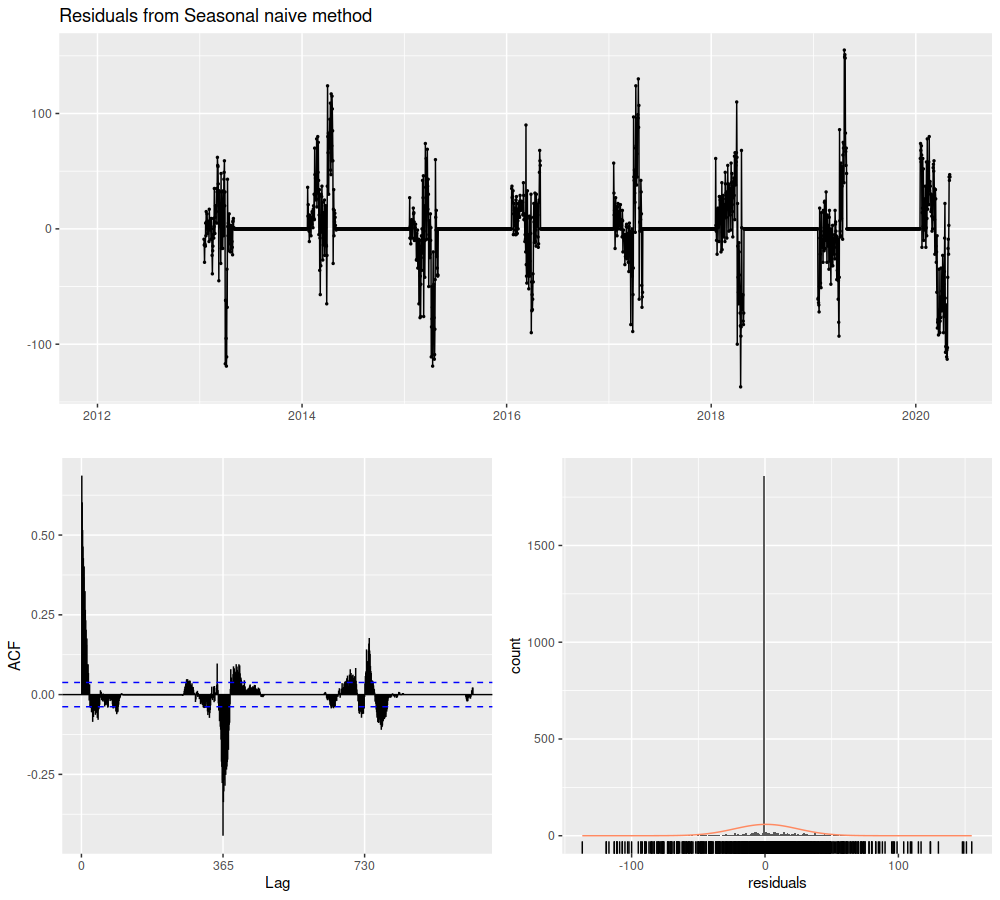

In [80]:
%%R 

checkresiduals(fc_sn_ms)

# SARIMA

In [66]:
%%R 

fit_sarima_ms <- auto.arima(one_daily_full_zero_train_ms, seasonal=FALSE)

fit_sarima_ms %>% forecast(h=length(one_daily_full_zero_test_ms)) -> fc_sarima_ms

autoplot(fc_sarima_ms) -> plot_fc_sarima_ms

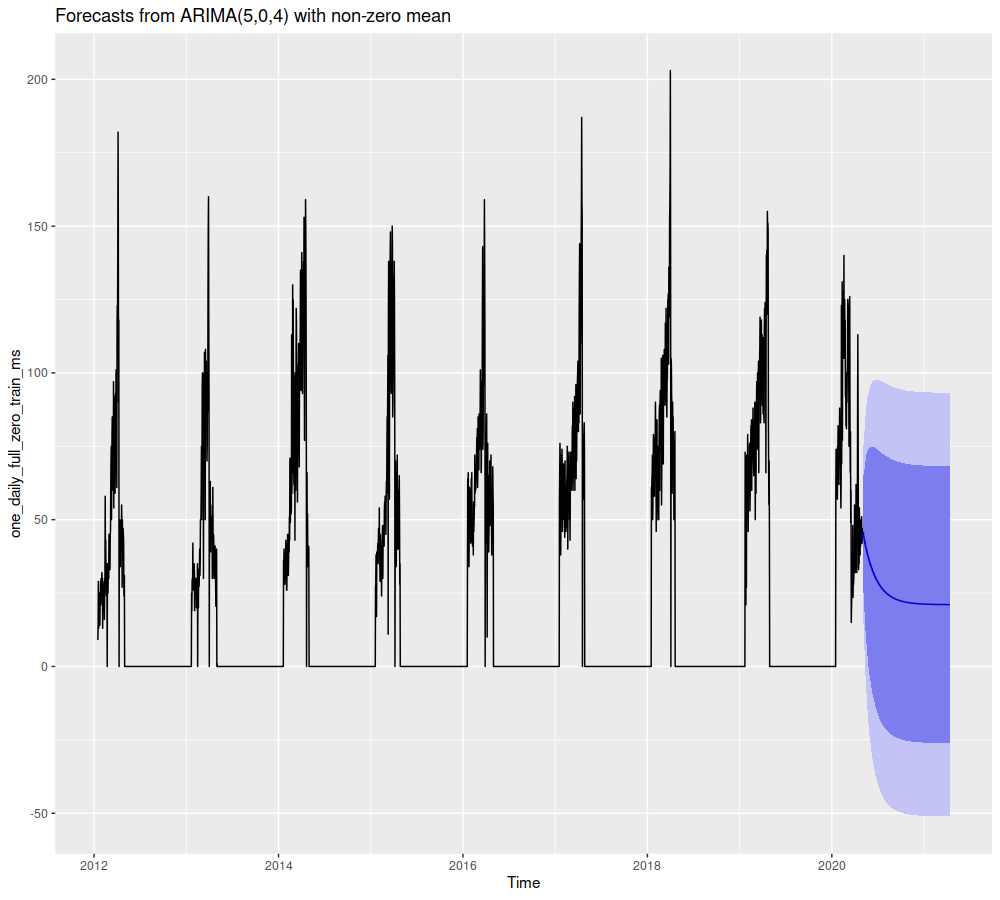

In [67]:
%%R

plot_fc_sarima_ms

In [78]:
%%R 

summary(fit_sarima_ms)

Series: one_daily_full_zero_train_ms 
ARIMA(5,0,4) with non-zero mean 

Coefficients:
         ar1     ar2      ar3      ar4     ar5     ma1      ma2      ma3
      0.4398  1.2670  -0.3917  -0.7773  0.4442  0.2010  -1.0232  -0.2088
s.e.  0.0604  0.0461   0.0728   0.0483  0.0390  0.0592   0.0671   0.0421
         ma4     mean
      0.5966  21.0488
s.e.  0.0392   6.5330

sigma^2 estimated as 137.2:  log likelihood=-11744.42
AIC=23510.84   AICc=23510.93   BIC=23577.01

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set 0.01415393 11.69535 4.971467 NaN  Inf 0.5146063 -0.005647105


In [69]:
%%R

mse_sarima_ms = mse(fc_sarima_ms$mean,one_daily_full_zero_test_ms)
rmse_sarima_ms =rmse(fc_sarima_ms$mean,one_daily_full_zero_test_ms)

print(mse_sarima_ms)
print(rmse_sarima_ms)

[1] 1475.375
[1] 38.41061



	Ljung-Box test

data:  Residuals from ARIMA(5,0,4) with non-zero mean
Q* = 900.97, df = 596, p-value = 7.994e-15

Model df: 10.   Total lags used: 606



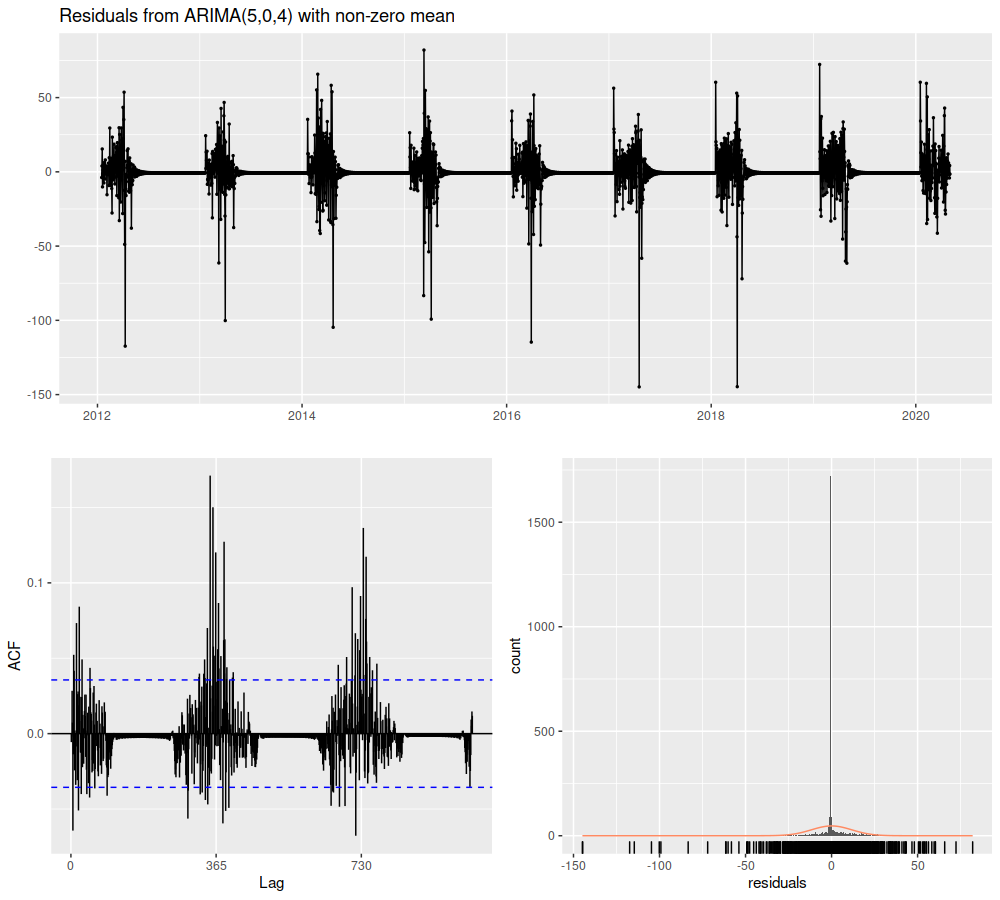

In [70]:
%%R 

checkresiduals(fc_sarima_ms)

# SARIMA + dummy variable

In [81]:
%%R 

fit_sarima_ms_dum <- auto.arima(one_daily_full_zero_train_ms, xreg = one_dum_train_ms, seasonal=FALSE)

fit_sarima_ms_dum %>% forecast(one_dum_train_ms, xreg=one_dum_test_ms, h=length(one_daily_full_zero_test_ms)) -> fc_sarima_ms_dum

autoplot(fc_sarima_ms_dum) -> plot_fc_sarima_ms_dum

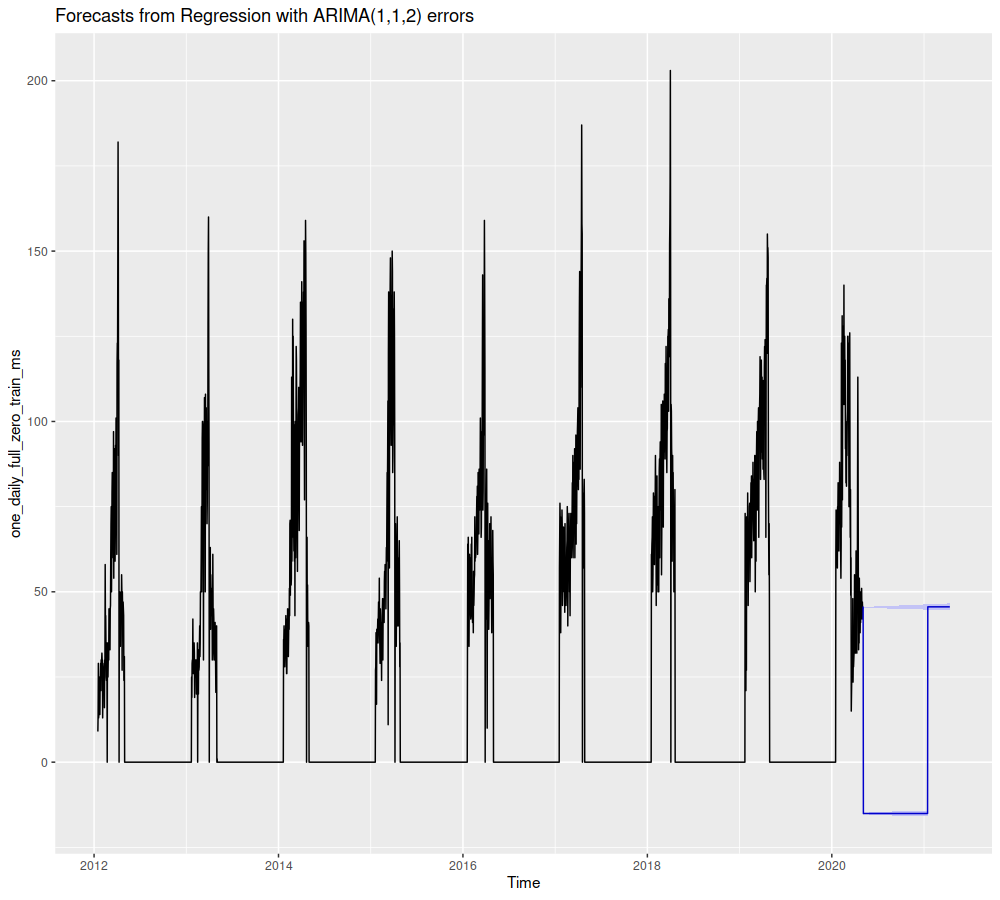

In [82]:
%%R

plot_fc_sarima_ms_dum

In [83]:
%%R 

summary(fit_sarima_ms_dum)

Series: one_daily_full_zero_train_ms 
Regression with ARIMA(1,1,2) errors 

Coefficients:
         ar1      ma1     ma2      xreg
      0.4951  -0.9028  0.1133  -60.6540
s.e.  0.0926   0.0947  0.0514    1.7916

sigma^2 estimated as 103.9:  log likelihood=-11320.78
AIC=22651.56   AICc=22651.58   BIC=22681.64

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set 0.02744706 10.18364 4.097823 NaN  Inf 0.4241736 -0.001851543


In [130]:
%%R
mse_sarima_ms_dum = mse(fc_sarima_ms_dum$mean,one_daily_full_zero_test_ms)
rmse_sarima_ms_dum = rmse(fc_sarima_ms_dum$mean,one_daily_full_zero_test_ms)

print(mse_sarima_ms_dum)
print(rmse_sarima_ms_dum)

[1] 566.2146
[1] 23.79526



	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,1,2) errors
Q* = 1862, df = 602, p-value < 2.2e-16

Model df: 4.   Total lags used: 606



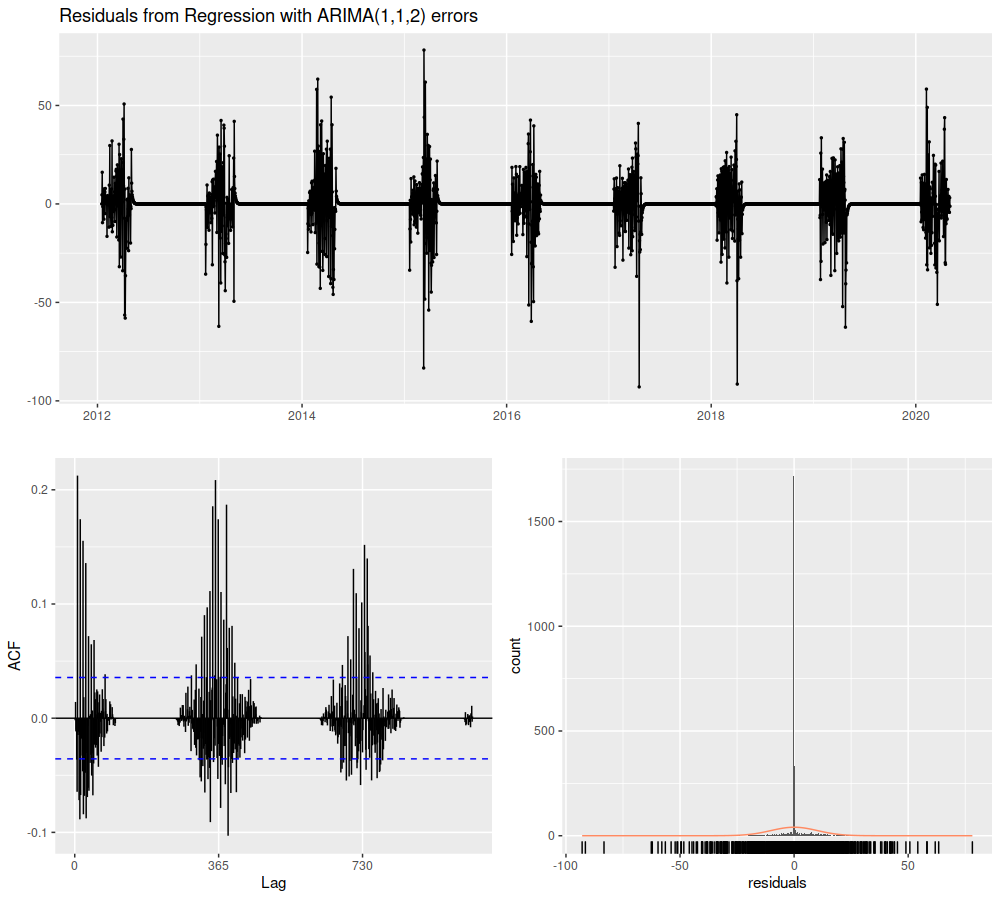

In [85]:
%%R 

checkresiduals(fc_sarima_ms_dum)

# TBATS

In [76]:
%%R

one_daily_full_zero_train_ms %>% tbats -> fit_tbats_ms

fit_tbats_ms %>% forecast(h=length(one_daily_full_zero_test_ms)) -> fc_tbats_ms

autoplot(fc_tbats_ms) -> plot_fc_tbats_ms

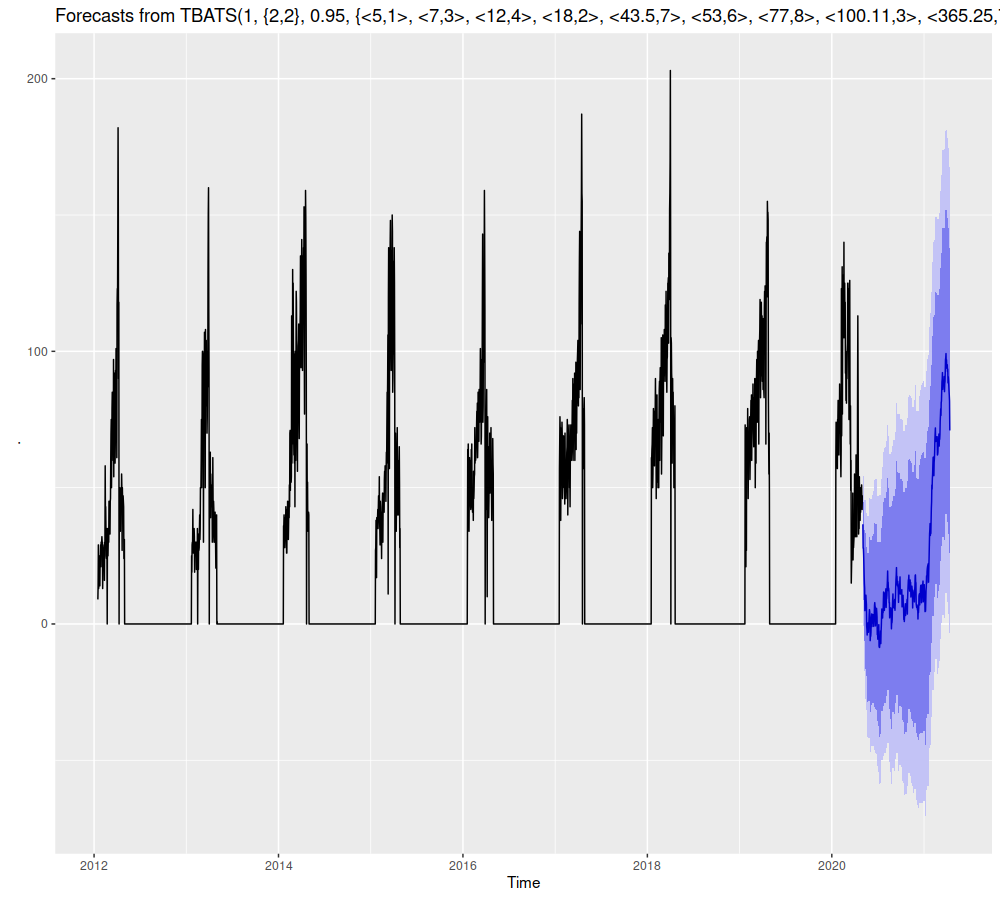

In [86]:
%%R

plot_fc_tbats_ms

In [87]:
%%R

mse_tbats_ms = mse(fc_tbats_ms$mean,one_daily_full_zero_test_ms)
rmse_tbats_ms = rmse(fc_tbats_ms$mean,one_daily_full_zero_test_ms)

print(mse_tbats_ms)
print(rmse_tbats_ms)

[1] 175.7504
[1] 13.25709



	Ljung-Box test

data:  Residuals from TBATS(1, {2,2}, 0.95, {<5,1>, <7,3>, <12,4>, <18,2>, <43.5,7>, <53,6>, <77,8>, <100.11,3>, <365.25,7>})
Q* = 1157.1, df = 493, p-value < 2.2e-16

Model df: 113.   Total lags used: 606



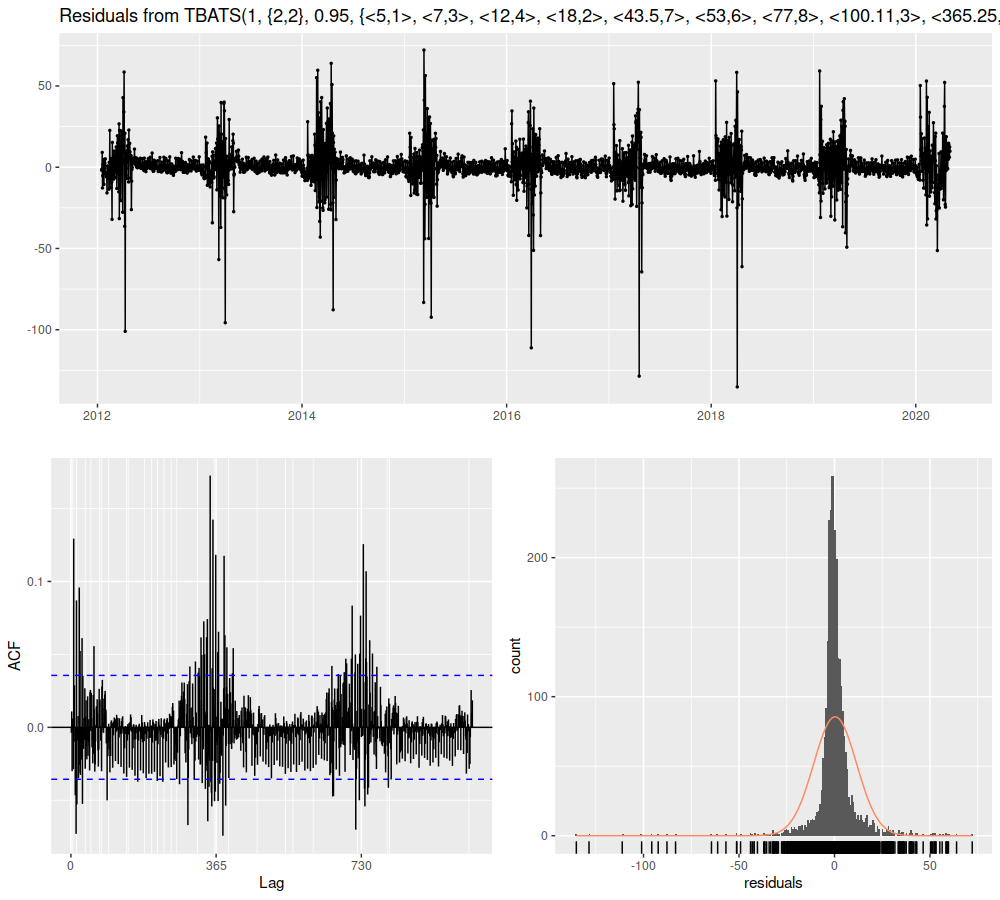

In [88]:
%%R 

checkresiduals(fc_tbats_ms)

# TBATS + dummy variables

In [89]:
%%R

one_daily_full_zero_train_ms %>% tbats(xreg = one_dum_train_ms) -> fit_tbats_ms_dum

fit_tbats_ms_dum %>% forecast(xreg=one_dum_test_ms, h=length(one_daily_full_zero_test_ms)) -> fc_tbats_ms_dum

autoplot(fc_tbats_ms_dum) -> plot_fc_tbats_ms_dum

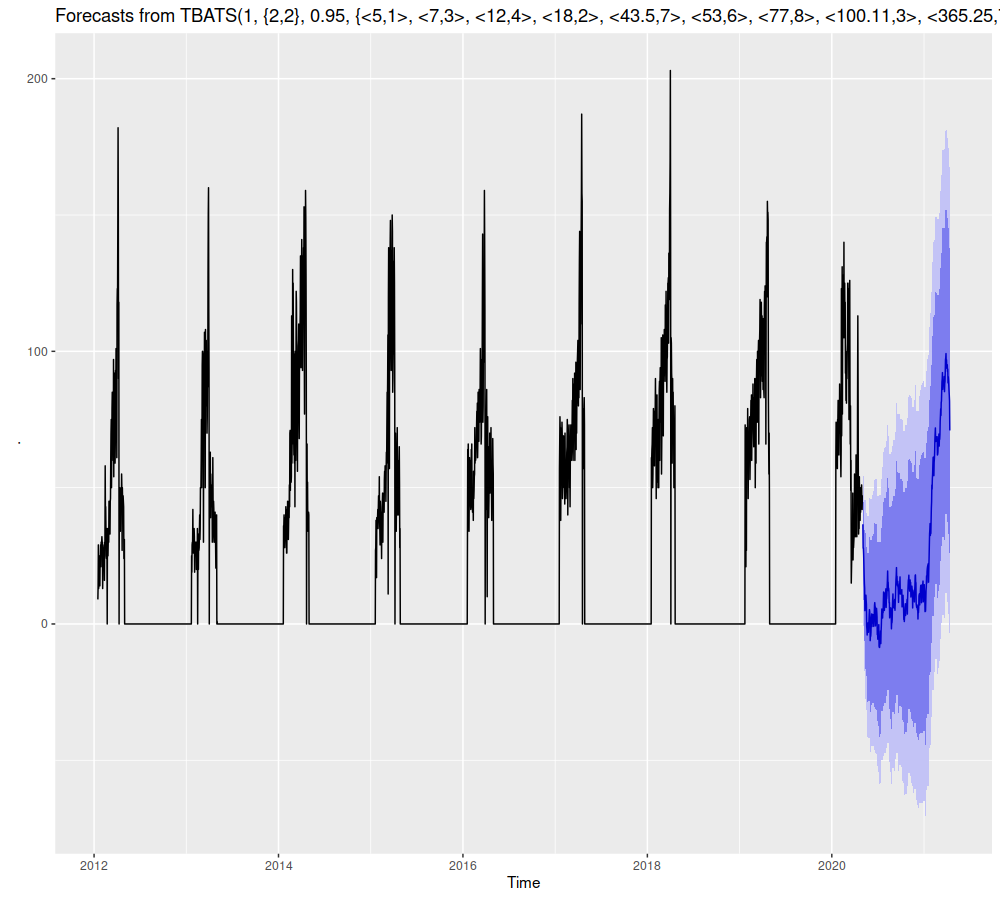

In [91]:
%%R

plot_fc_tbats_ms_dum

In [92]:
%%R

mse_tbats_ms_dum = mse(fc_tbats_ms_dum$mean,one_daily_full_zero_test_ms)
rmse_tbats_ms_dum = rmse(fc_tbats_ms_dum$mean,one_daily_full_zero_test_ms)

print(mse_tbats_ms)
print(rmse_tbats_ms)

[1] 175.7504
[1] 13.25709



	Ljung-Box test

data:  Residuals from TBATS(1, {2,2}, 0.95, {<5,1>, <7,3>, <12,4>, <18,2>, <43.5,7>, <53,6>, <77,8>, <100.11,3>, <365.25,7>})
Q* = 1157.1, df = 493, p-value < 2.2e-16

Model df: 113.   Total lags used: 606



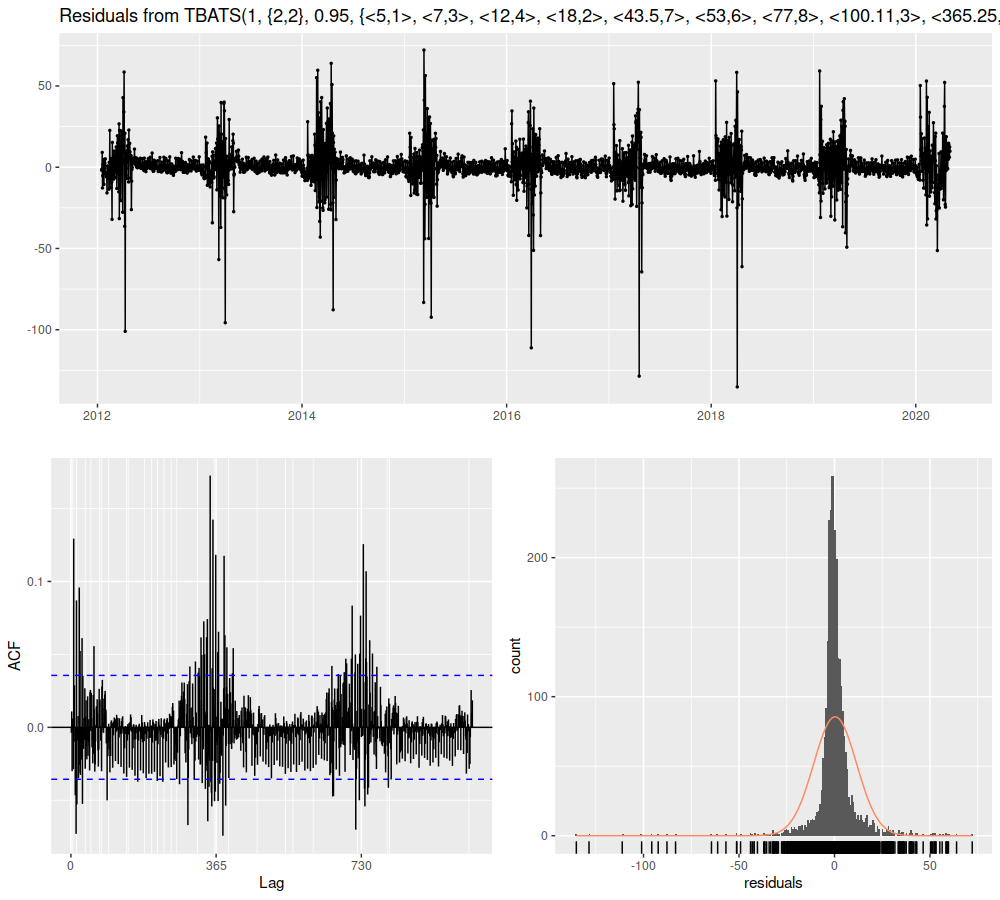

In [93]:
%%R 

checkresiduals(fc_tbats_ms_dum)

# Comparison

In [152]:
%%R 

compare_plot <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_sn, series='SN', PI=FALSE) +
                  autolayer(fc_sarima, series='SARIMA', PI=FALSE) +
                  autolayer(fc_sarima_dum, series='SARIMA_D', PI=FALSE) +
                  autolayer(fc_tbats, series='TBATS', PI=FALSE) +
                  autolayer(fc_tbats_dum, series='TBATS_D', PI=FALSE) +
                  autolayer(fc_sn_ms, series='SN_ms', PI=FALSE) +
                  autolayer(fc_sarima_ms, series='SARIMA_ms', PI=FALSE) +
                  autolayer(fc_sarima_ms_dum, series='SARIMA_ms_D', PI=FALSE) +
                  autolayer(fc_tbats_ms, series='TBATS_ms', PI=FALSE) +
                  autolayer(fc_tbats_ms_dum, series='TBATS_ms_D', PI=FALSE) 
  
  

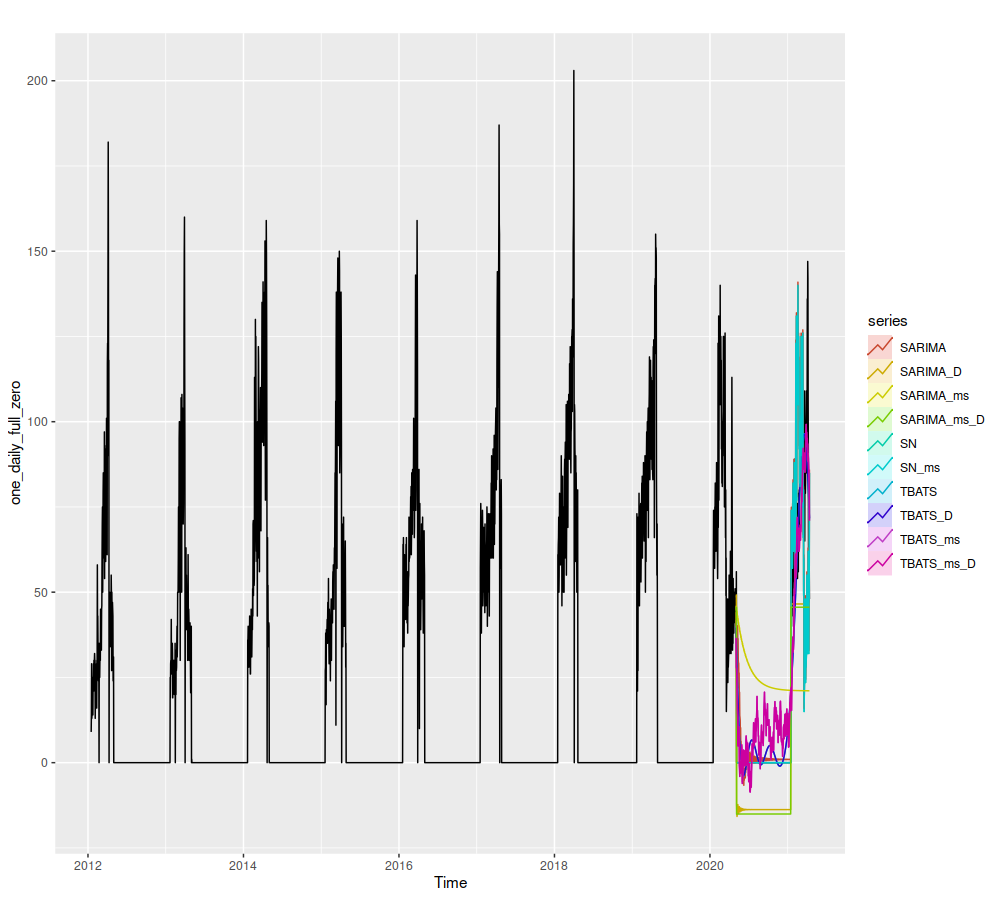

In [153]:
%%R 

compare_plot

In [154]:
%%R

png(filename='images/R_compare_all.png')
compare_plot

In [155]:
%%R 

sarima_plot <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_sarima, series='SARIMA', PI=FALSE) +
                  autolayer(fc_sarima_dum, series='SARIMA_D', PI=FALSE) +
                  autolayer(fc_sarima_ms, series='SARIMA_ms', PI=FALSE) +
                  autolayer(fc_sarima_ms_dum, series='SARIMA_ms_D', PI=FALSE) +
                  ylab('amount_sold') +
                  ggtitle('Compare SARIMA')

In [156]:
%%R

png(filename='images/R_compare_sarima.png')
sarima_plot

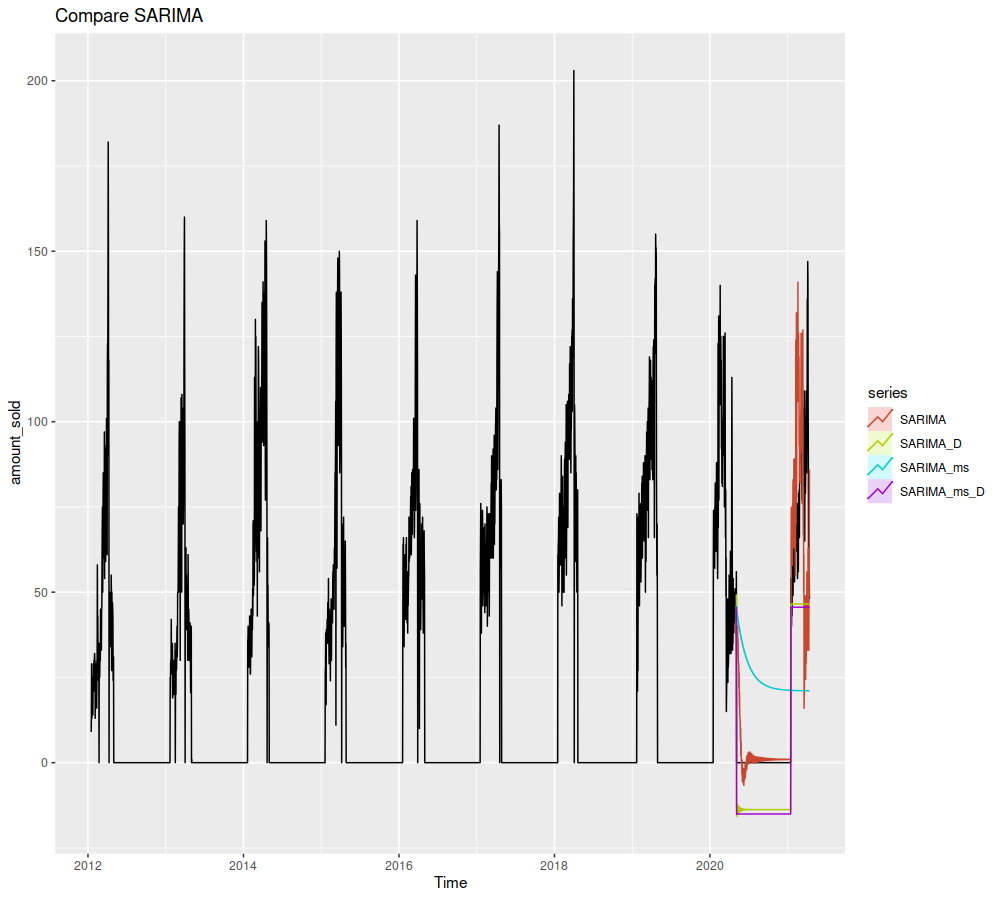

In [157]:
%%R

sarima_plot

In [171]:
%%R

tbats_plot <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_tbats, series='TBATS', PI=FALSE) +
                  autolayer(fc_tbats_dum, series='TBATS_D', PI=FALSE) +
                  autolayer(fc_tbats_ms, series='TBATS_ms', PI=FALSE) +
                  autolayer(fc_tbats_ms_dum, series='TBATS_ms_D', PI=FALSE)  +
                  ylab('amount_sold') +
                  ggtitle('Compare TBATS')

In [191]:
%%R

graphics.off()
png(filename='images/R_compare_tbats.png')
tbats_plot

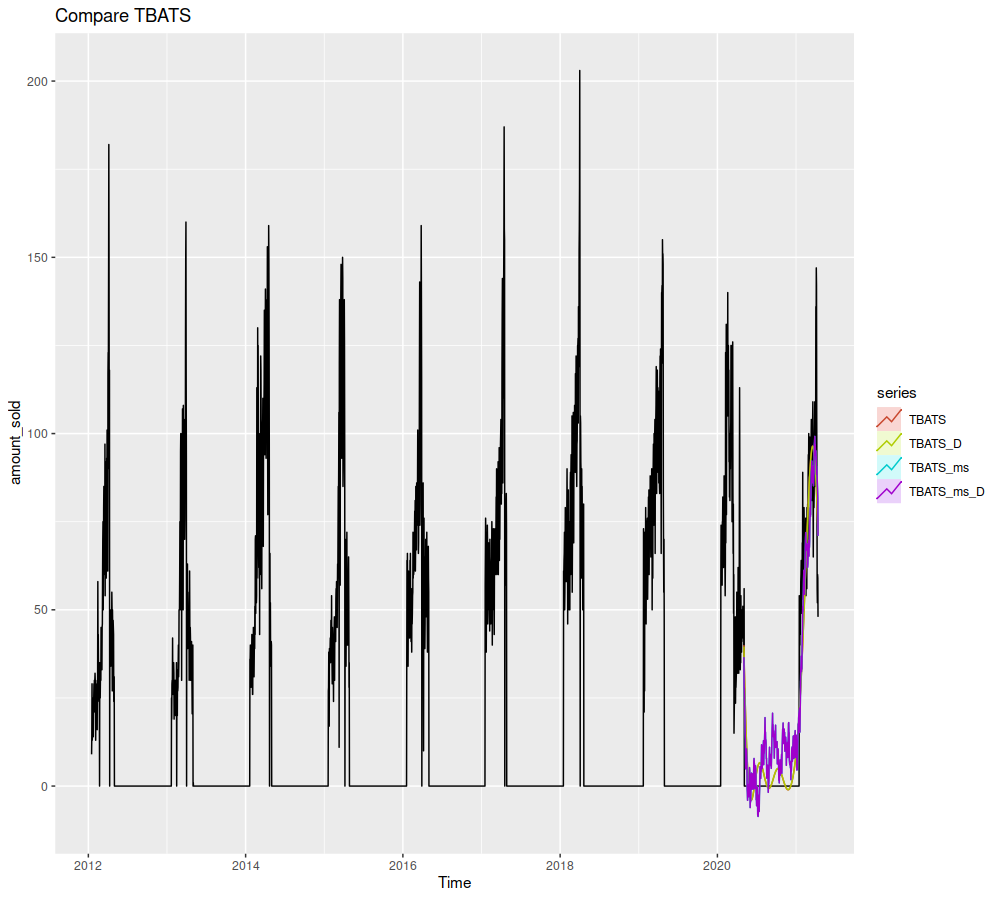

In [173]:
%%R

tbats_plot

In [174]:
%%R

sn_plot <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_sn, series='SN', PI=FALSE) +
                  autolayer(fc_sn_ms, series='SN_ms', PI=FALSE) +
                  ylab('amount_sold') +
                  ggtitle('Compare SN')


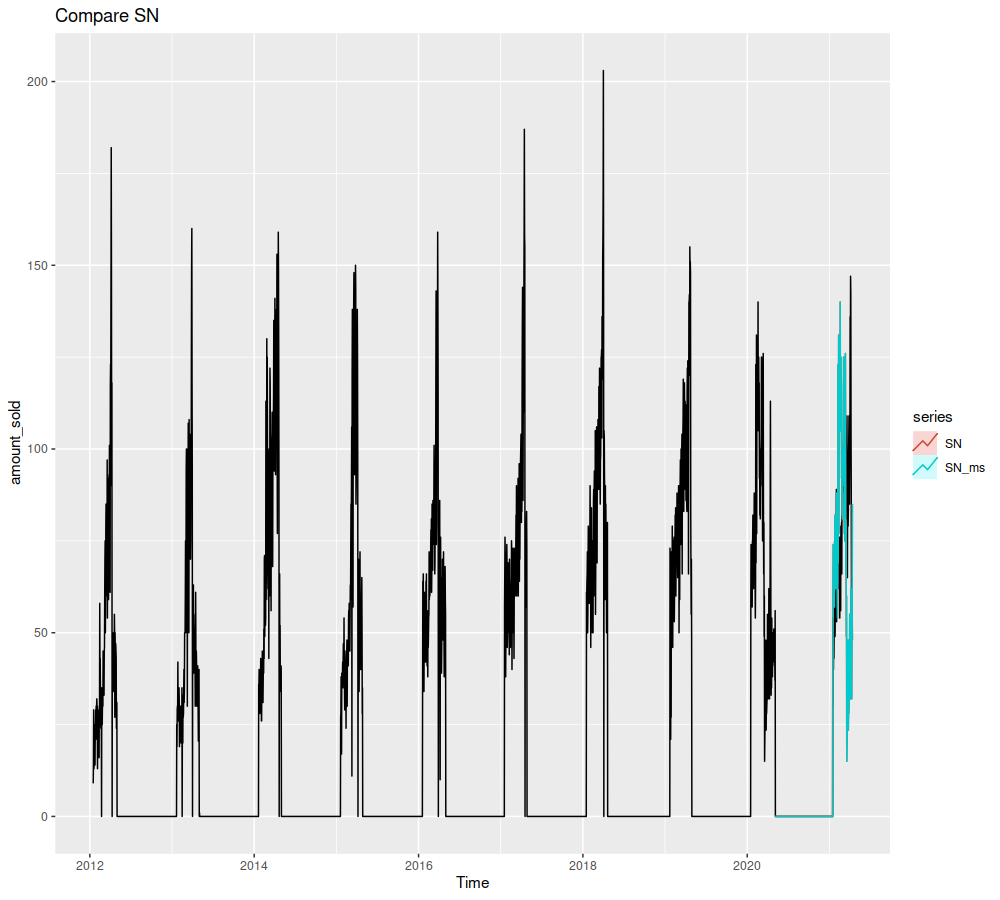

In [175]:
%%R

sn_plot 

In [162]:
%%R

s_t_plot <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_tbats, series='TBATS', PI=FALSE) +
                  autolayer(fc_sarima, series='SARIMA', PI=FALSE) +
                  ylab('amount_sold') +
                  ggtitle('TBATS vs SARIMA')

In [192]:
%%R

graphics.off()
png(filename='images/R_tbats_vs_sarima.png')
s_t_plot

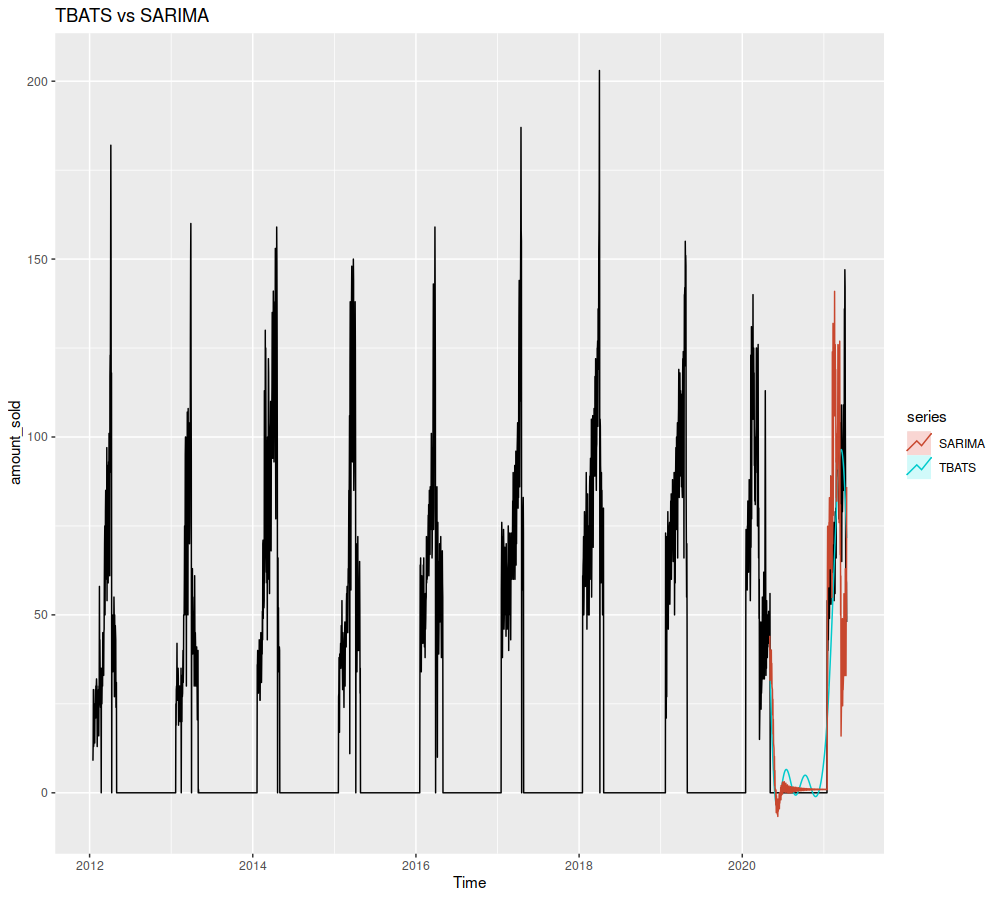

In [164]:
%%R 

s_t_plot

In [165]:
%%R 

tbats_vs <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_tbats, series='TBATS', PI=FALSE) +
                  autolayer(fc_tbats_ms, series='TBATS_ms', PI=FALSE) +
                  ylab('amount_sold') +
                  ggtitle('TBATS vs TBATS_ms')

In [193]:
%%R

graphics.off()
png(filename='images/R_tbats_vs_ms.png')
tbats_vs

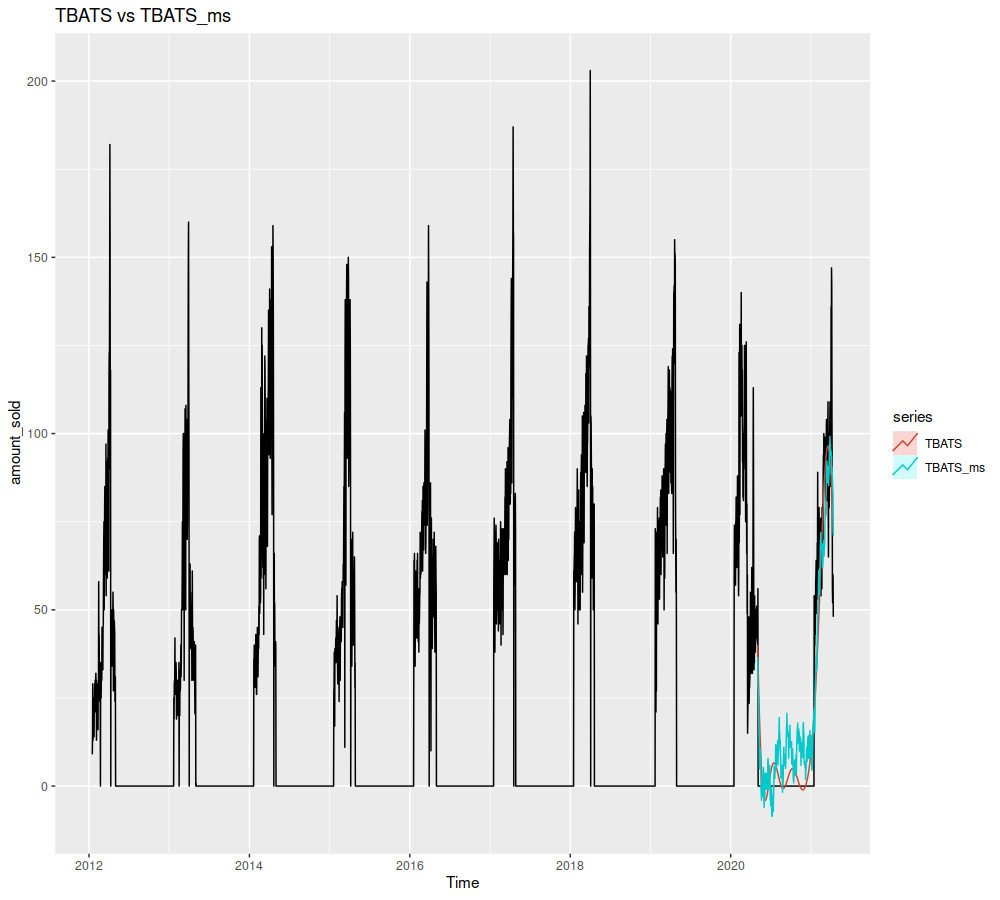

In [167]:
%%R 

tbats_vs

In [168]:
%%R 

sarima_vs <- autoplot(one_daily_full_zero) + 
                  autolayer(fc_sarima, series='SARIMA', PI=FALSE) +
                  autolayer(fc_sarima_ms, series='SARIMA_ms', PI=FALSE) +
                  ylab('amount_sold') +
                  ggtitle('SARIMA vs SARIMA_ms')

In [190]:
%%R

graphics.off()
png(filename='images/R_sarima_vs_ms.png')
sarima_vs

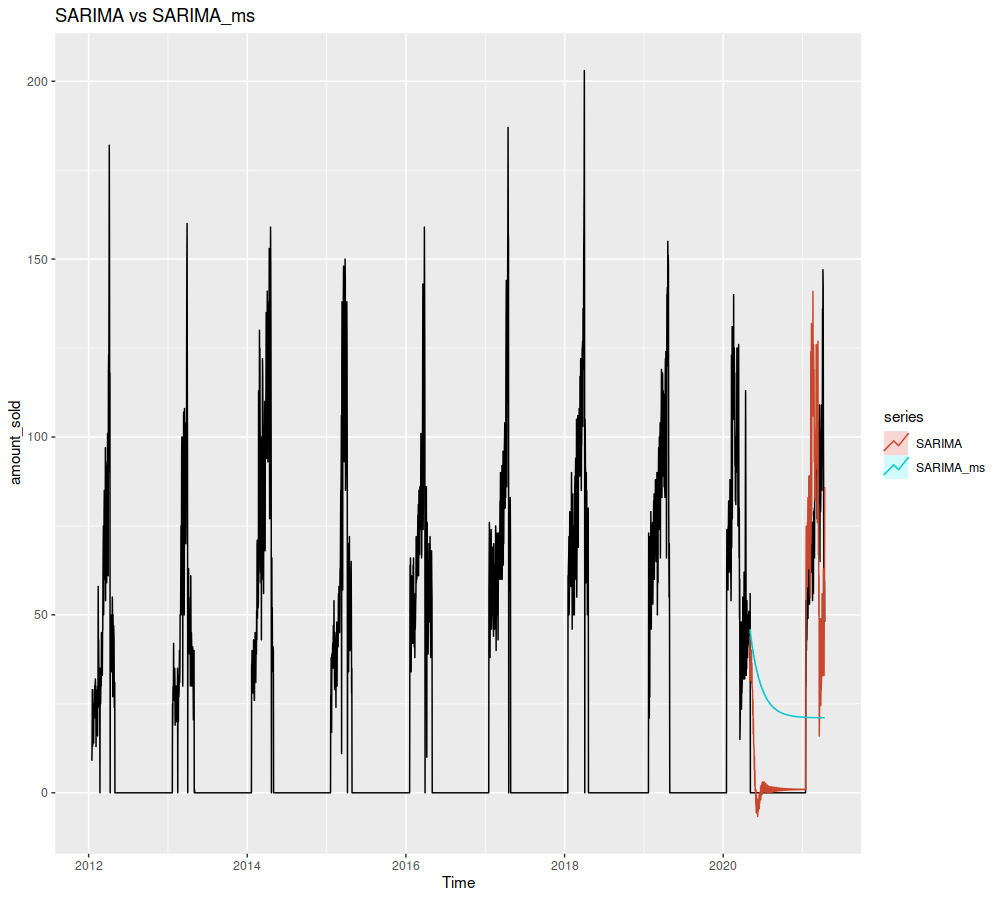

In [170]:
%%R 

sarima_vs

# Summary

## RMSE's
To compare the models and to determine which is the best, the RMSE is used here.

In [102]:
%R sprintf('seasonal naiv: %s', rmse_sn)

'seasonal naiv: 21.8997220550161'


In [131]:
%%R

print(sprintf('seasonal naiv: %s', signif(rmse_sn),digits=4))
print(sprintf('SARIMA: %s', signif(rmse_sarima),digits=4))
print(sprintf('SARIMA + DUMMY: %s', signif(rmse_sarima_dum),digits=4))
print(sprintf('TBATS: %s', signif(rmse_tbats),digits=4))
print(sprintf('TBATS + DUMMY: %s', signif(rmse_tbats_dum),digits=4))
print('---')
print(sprintf('seasonal naiv ms: %s', signif(rmse_sn_ms),digits=4))
print(sprintf('SARIMA ms: %s', signif(rmse_sarima_ms),digits=4))
print(sprintf('SARIMA ms + DUMMY: %s', signif(rmse_sarima_ms_dum),digits=4))
print(sprintf('TBATS ms: %s', signif(rmse_tbats_ms),digits=4))
print(sprintf('#TBATS ms + DUMMYS: %s', signif(rmse_tbats_ms_dum),digits=4))

[1] "seasonal naiv: 21.8997"
[1] "SARIMA: 22.6669"
[1] "SARIMA + DUMMY: 22.8759"
[1] "TBATS: 11.6128"
[1] "TBATS + DUMMY: 11.611"
[1] "---"
[1] "seasonal naiv ms: 21.8997"
[1] "SARIMA ms: 38.4106"
[1] "SARIMA ms + DUMMY: 23.7953"
[1] "TBATS ms: 13.2571"
[1] "#TBATS ms + DUMMYS: 13.2571"


## Conclusion

+ Across all the different variants, the SARIMA model performed the worst
+ The msts had no influence at all on the seasonal naïve
+ The dummies had no influence at all on TBATS
+ Only SARIMA with ms could benefit from the dummies
+ SARIMA required the longest calculation time, which could, however, be significantly shortened by the dummies (the pure auto.arima needs the longesz)
+ Best performance was achieved by TBATS without ms

## Improvement possibilities

+ Autmatisation of the frequency search
+ Model that can handle dummy variables (not only as dyamic regression)
+ Dummies for (moving) holidays
+ Trying out other models e.g. HW
+ Combination of ML models
+ Transition to deep learning
+ More training data

## MSE

In [149]:
%%R

print(sprintf('seasonal naiv: %s', signif(mse_sn),digits=4))
print(sprintf('SARIMA: %s', signif(mse_sarima),digits=4))
print(sprintf('SARIMA + DUMMY: %s', signif(mse_sarima_dum),digits=4))
print(sprintf('TBATS: %s', signif(mse_tbats),digits=4))
print(sprintf('TBATS + DUMMY: %s', signif(mse_tbats_dum),digits=4))
print('---')
print(sprintf('seasonal naiv ms: %s', signif(mse_sn_ms),digits=4))
print(sprintf('SARIMA ms: %s', signif(mse_sarima_ms),digits=4))
print(sprintf('SARIMA ms + DUMMY: %s', signif(mse_sarima_ms_dum),digits=4))
print(sprintf('TBATS ms: %s', signif(mse_tbats_ms),digits=4))
print(sprintf('#TBATS ms + DUMMYS: %s', signif(mse_tbats_ms_dum),digits=4))

[1] "seasonal naiv: 479.598"
[1] "SARIMA: 513.787"
[1] "SARIMA + DUMMY: 523.308"
[1] "TBATS: 134.857"
[1] "TBATS + DUMMY: 134.816"
[1] "---"
[1] "seasonal naiv ms: 479.598"
[1] "SARIMA ms: 1475.38"
[1] "SARIMA ms + DUMMY: 566.215"
[1] "TBATS ms: 175.75"
[1] "#TBATS ms + DUMMYS: 175.75"


# Save plots

In [178]:
%%R

png(filename='images/R_plot_fc_sn.png') 
plot_fc_sn
png(filename='images/R_plot_fc_sarima.png') 
plot_fc_sarima
png(filename='images/R_plot_fc_sarima_dum.png')
plot_fc_sarima_dum
png(filename='images/R_plot_fc_tbats.png')
plot_fc_tbats
png(filename='images/R_plot_fc_tbats_dum.png')
plot_fc_tbats_dum

In [181]:
%%R

png(filename='images/R_plot_fc_sn_ms.png')
plot_fc_sn_ms
png(filename='images/R_plot_fc_sarima_ms.png')
plot_fc_sarima_ms
png(filename='images/R_plot_fc_sarima_ms_dum.png')
plot_fc_sarima_ms_dum
png(filename='images/R_plot_fc_tbats_ms.png')
plot_fc_tbats_ms
png(filename='images/R_plot_fc_tbats_ms_dum.png')
plot_fc_tbats_ms_dum

In [189]:
%%R

graphics.off()
png(filename='images/R_plot_fc_sn_ms.png')
plot_fc_sn_ms
